# **Analysis for Final Project**
## **Unemployment Rates, 3 Stock Market Indices, Interest Rates, Inflation Rates** 
### Molly Scheitler

In [2]:
# Import packages 

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy import stats
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, r2_score, confusion_matrix, classification_report 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, Holt
from statsmodels.tsa.api import SimpleExpSmoothing
from tbats import TBATS
from statsmodels.tsa.stattools import adfuller
from scipy.stats import zscore

import numpy as np
import statsmodels.api as sm

# **Description of Data**

# The data I used is integrated into one final pandas DataFrame (final_dataset). I acquired the unemployment rate data from a .csv file from the Federal Reserve Bank of St. Louis (https://fred.stlouisfed.org/series/UNRATE). The data spanned from January 1948 to February 2025. I found the closing stock prices of different indexes (^GSPC, ^IXIC, ^DJI) from the Yahoo Finance API. The ^GSPC data spanned from January 1929 to March 2025. The ^IXIC data spanned from February 1971 to February 2025. The ^DJI data spanned from January 1992 to February 2025. As for the interest rates, I found a .csv file from the Federal Reserve Bank of St. Louis (https://fred.stlouisfed.org/series/FEDFUNDS). This data spanned from July 1954 to February 2025. Finally, I acquired the inflation rate data from web scraping (https://www.usinflationcalculator.com/inflation/historical-inflation-rates/). The data spanned from January 1914 to February 2025.

# **Descriptive Statistics**

# **Univariate**

# **Question:** How is my data distributed? Are there outliers needing to be removed? 

In [8]:
# Read in the file of clean, merged data called mscheitler_Final_Cleaned_Dataset and call it final_dataset 

final_dataset = pd.read_csv("mscheitler_Final_Cleaned_Dataset.csv", sep=',', encoding='utf-8')

In [9]:
# Display the final_dataset pandas DataFrame 

display(final_dataset)

,Date,Unemployment_Rate,^GSPC,^IXIC,^DJI,Interest_Rate,Inflation_Rate
0,1992-01-31,7.3,408.78,620.21,3223.40,4.03,2.6
1,1992-02-29,7.4,412.70,633.47,3267.70,4.06,2.8
2,1992-03-31,7.4,403.69,603.77,3235.50,3.98,3.2
3,1992-04-30,7.4,414.95,578.68,3359.10,3.73,3.2
4,1992-05-31,7.6,415.35,585.31,3396.90,3.82,3.0
...,...,...,...,...,...,...,...
393,2024-10-31,4.1,5705.45,18095.15,41763.46,4.83,2.6
394,2024-11-30,4.2,6032.38,19218.17,44910.65,4.64,2.7
395,2024-12-31,4.1,5881.63,19310.79,42544.22,4.48,2.9
396,2025-01-31,4.0,6040.53,19627.44,44544.66,4.33,3.0


# **Removing Outliers**

In [11]:
# Select only numeric columns (exclude 'Date')
numeric_cols = final_dataset.select_dtypes(include='number')

# Step 2: Calculate IQR for each column
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Step 3: Create a boolean mask — True if no outliers in that row
mask = ~((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))).any(axis=1)

# Step 4: Apply mask to original df (preserves all columns including 'Date')
final_dataset2 = final_dataset[mask]

# Optional: Reset index if needed
final_dataset2.reset_index(drop=True, inplace=True)

In [12]:
# Display the final_dataset pandas DataFrame with no outliers 

display(final_dataset2)

,Date,Unemployment_Rate,^GSPC,^IXIC,^DJI,Interest_Rate,Inflation_Rate
0,1992-01-31,7.3,408.78,620.21,3223.40,4.03,2.6
1,1992-02-29,7.4,412.70,633.47,3267.70,4.06,2.8
2,1992-03-31,7.4,403.69,603.77,3235.50,3.98,3.2
3,1992-04-30,7.4,414.95,578.68,3359.10,3.73,3.2
4,1992-05-31,7.6,415.35,585.31,3396.90,3.82,3.0
...,...,...,...,...,...,...,...
319,2019-11-30,3.6,3140.98,8665.47,28051.41,1.55,2.1
320,2019-12-31,3.6,3230.78,8972.60,28538.44,1.55,2.3
321,2020-01-31,3.6,3225.52,9150.94,28256.03,1.55,2.5
322,2020-02-29,3.5,2954.22,8567.37,25409.36,1.58,2.3


In [13]:
# Find the data types of the final_dataset pandas DataFrame 

final_dataset2.dtypes

Date                  object
Unemployment_Rate    float64
^GSPC                float64
^IXIC                float64
^DJI                 float64
Interest_Rate        float64
Inflation_Rate       float64
dtype: object

In [14]:
# Convert Date column to a datetime format to correct the data type (the others are perfect)

final_dataset2.loc[:, "Date"] = pd.to_datetime(final_dataset2["Date"])

In [15]:
# Find the data types of the final_dataset pandas DataFrame 

final_dataset2.dtypes

Date                  object
Unemployment_Rate    float64
^GSPC                float64
^IXIC                float64
^DJI                 float64
Interest_Rate        float64
Inflation_Rate       float64
dtype: object

# Unemployment_Rate Column

In [17]:
# Find all unique values in the Unemployment_Rate column 

print(final_dataset2["Unemployment_Rate"].unique())

[7.3 7.4 7.6 7.8 7.7 7.1 7.  6.9 6.8 6.7 6.6 6.5 6.4 6.1 6.  5.9 5.8 5.6
 5.5 5.4 5.7 5.3 5.1 5.2 4.9 5.  4.8 4.7 4.6 4.3 4.4 4.5 4.2 4.1 4.  3.8
 3.9 6.3 6.2 8.3 8.7 9.6 9.4 9.5 9.3 9.1 9.  8.8 8.6 8.5 8.2 8.1 7.9 8.
 7.5 7.2 3.7 3.6 3.5]


In [18]:
# Use the .describe() function to find the descriptive statistics of the Unemployment_Rate column 

print("Descriptive Statistics of Unemployment_Rate column:\n")

descriptive_statistics = final_dataset2["Unemployment_Rate"].describe()

display(descriptive_statistics)

Descriptive Statistics of Unemployment_Rate column:



count    324.000000
mean       5.627469
std        1.459596
min        3.500000
25%        4.500000
50%        5.400000
75%        6.300000
max        9.600000
Name: Unemployment_Rate, dtype: float64

In [19]:
# Define the pandas DataFrame and Unemployment_Rate column 

column = final_dataset2["Unemployment_Rate"]
column_name = "Unemployment_Rate"

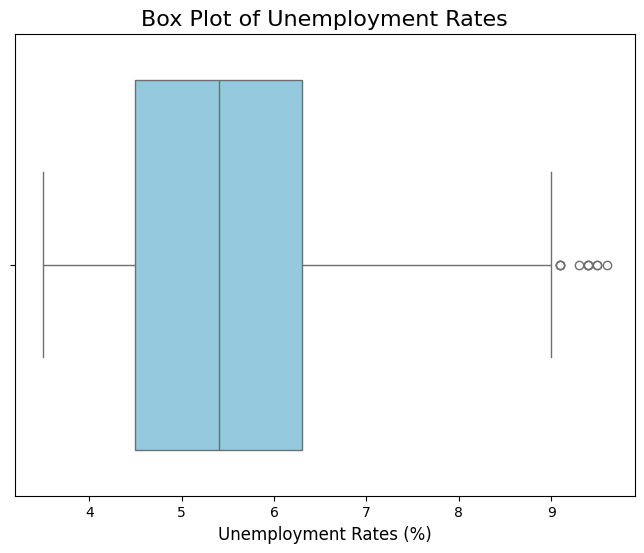

In [20]:
# Create a boxplot of the Unemployment_Rate column data 

# Set plot size
plt.figure(figsize=(8, 6))

# Create a box plot for 'Unempployment_Rate'
sns.boxplot(x=column, color="skyblue")

# Add title and labels
plt.title("Box Plot of Unemployment Rates", fontsize=16)
plt.xlabel("Unemployment Rates (%)", fontsize=12)

# Display the plot
plt.show()

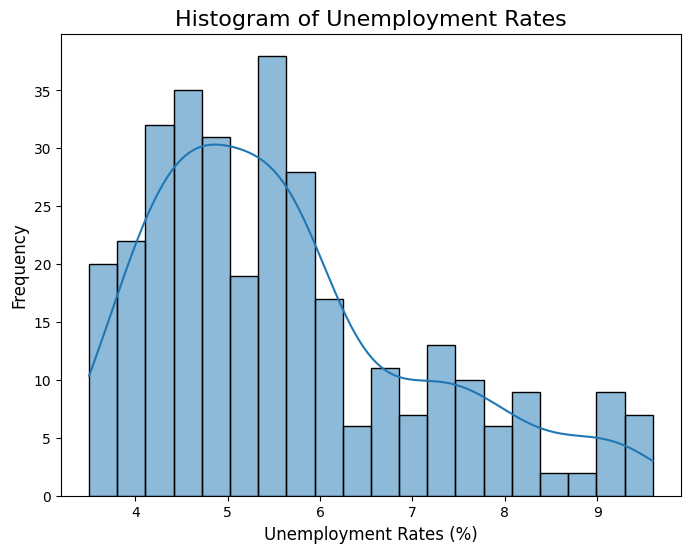

In [21]:
# Create a histogram of the Unemployment_Rate column 

# Set plot size
plt.figure(figsize=(8, 6))

# Create a histogram for 'Unemployment_Rate'
sns.histplot(column, bins=20, kde=True)

# Add title and labels
plt.title("Histogram of Unemployment Rates", fontsize=16)
plt.xlabel("Unemployment Rates (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Display the plot
plt.show()

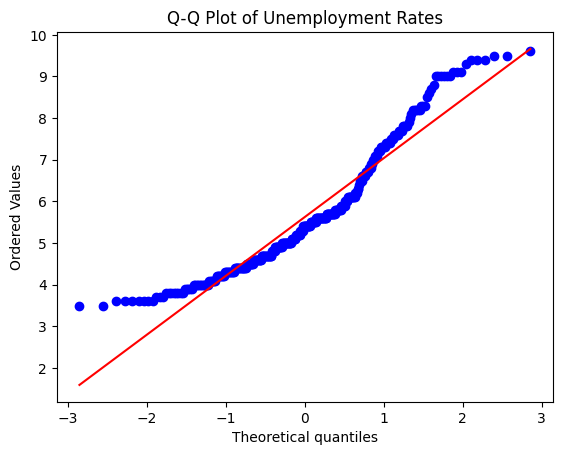

In [22]:
# Create a Q-Q plot for 'Unemployment_Rate'

# Create Q-Q plot 
stats.probplot(column, dist="norm", plot=plt)

# Add title
plt.title("Q-Q Plot of Unemployment Rates")

# Display the plot
plt.show()

In [23]:
# Complete the Shapiro-Wilk test for normality 

# Shapiro-Wilk test for normality
stat, p_value = stats.shapiro(column)

# Display the results
print(f"Unemployment Rate Shapiro-Wilk Test Statistic: {stat}")
print(f"Unemployment Rate P-Value: {p_value}")

# Interpretation
alpha = 0.05  # Significance level
if p_value > alpha:
    print("The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")

Unemployment Rate Shapiro-Wilk Test Statistic: 0.9221234917640686
Unemployment Rate P-Value: 6.062306472792711e-12
The data does not follow a normal distribution (reject H0).


# **Answer:** Unemployment Rates are heavily right-skewed with some outliers. 

# ^GSPC Column

In [26]:
# Find all unique values in the ^GSPC column 

print(final_dataset2["^GSPC"].unique())

[ 408.78  412.7   403.69  414.95  415.35  408.14  424.21  414.03  417.8
  418.68  431.35  435.71  438.78  443.38  451.67  440.19  450.19  450.53
  448.13  463.56  458.93  467.83  461.79  466.45  481.61  467.14  445.77
  450.91  456.5   444.27  458.26  475.49  462.71  472.35  453.69  459.27
  470.42  487.39  500.71  514.71  533.4   544.75  562.06  561.88  584.41
  581.5   605.37  615.93  636.02  640.43  645.5   654.17  669.12  670.63
  639.95  651.99  687.33  705.27  757.02  740.74  786.16  790.82  757.12
  801.34  848.28  885.14  954.31  899.47  947.28  914.62  955.4   970.43
  980.28 1049.34 1101.75 1111.75 1090.82 1133.84 1120.67  957.28 1017.01
 1098.67 1163.63 1229.23 1279.64 1238.33 1286.37 1335.18 1301.84 1372.71
 1328.72 1320.41 1282.71 1362.93 1388.91 1469.25 1394.46 1366.42 1498.58
 1452.43 1420.6  1454.6  1430.83 1517.68 1436.51 1429.4  1314.95 1320.28
 1366.01 1239.94 1160.33 1249.46 1255.82 1224.38 1211.23 1133.58 1040.94
 1059.78 1139.45 1148.08 1130.2  1106.73 1147.39 107

In [27]:
# Use the .describe() function to find the descriptive statistics of the ^GSPC column 

print("Descriptive Statistics of ^GSPC column:\n")

descriptive_statistics = final_dataset2["^GSPC"].describe()

display(descriptive_statistics)

Descriptive Statistics of ^GSPC column:



count     324.000000
mean     1363.023981
std       678.443951
min       403.690000
25%       916.707500
50%      1257.620000
75%      1631.297500
max      3230.780000
Name: ^GSPC, dtype: float64

In [28]:
# Define the pandas DataFrame and ^GSPC column 

column = final_dataset2["^GSPC"]
column_name = "^GSPC"

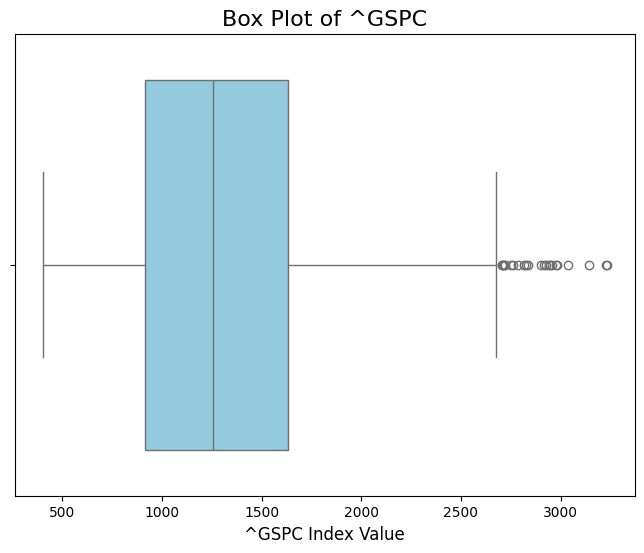

In [29]:
# Create a boxplot of the ^GSPC column data 

# Set plot size
plt.figure(figsize=(8, 6))

# Create a box plot for '^GSPC'
sns.boxplot(x=column, color="skyblue")

# Add title and labels
plt.title("Box Plot of ^GSPC", fontsize=16)
plt.xlabel("^GSPC Index Value", fontsize=12)

# Display the plot
plt.show()

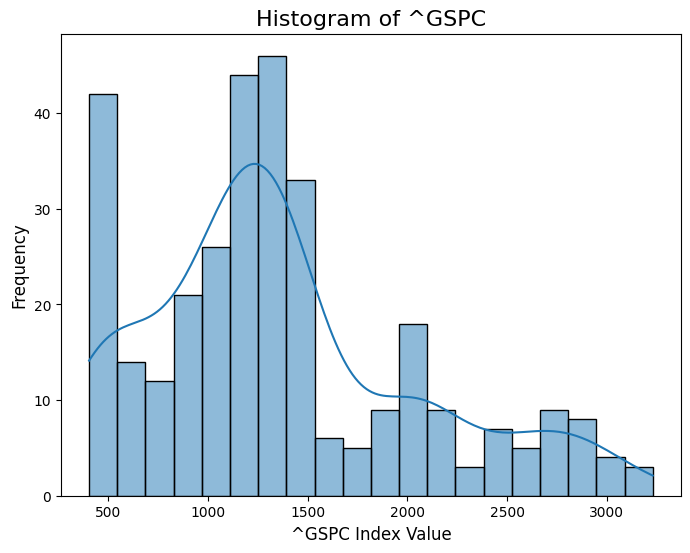

In [30]:
# Create a histogram of the ^GSPC column 

# Set plot size
plt.figure(figsize=(8, 6))

# Create a histogram for '^GSPC'
sns.histplot(column, bins=20, kde=True)

# Add title and labels
plt.title("Histogram of ^GSPC", fontsize=16)
plt.xlabel("^GSPC Index Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Display the plot
plt.show()

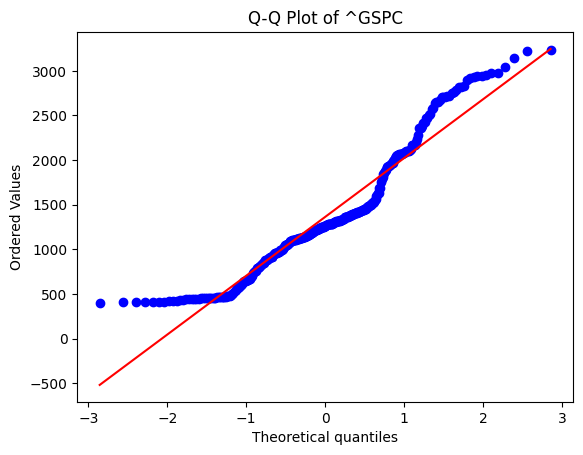

In [31]:
# Create a Q-Q plot for '^GSPC'

# Create Q-Q plot 
stats.probplot(column, dist="norm", plot=plt)

# Add title
plt.title("Q-Q Plot of ^GSPC")

# Display the plot
plt.show()

In [32]:
# Complete the Shapiro-Wilk test for normality 

# Shapiro-Wilk test for normality
stat, p_value = stats.shapiro(column)

# Display the results
print(f"^GSPC Shapiro-Wilk Test Statistic: {stat}")
print(f"^GSPC P-Value: {p_value}")

# Interpretation
alpha = 0.05  # Significance level
if p_value > alpha:
    print("The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")

^GSPC Shapiro-Wilk Test Statistic: 0.9290322661399841
^GSPC P-Value: 2.693127144903773e-11
The data does not follow a normal distribution (reject H0).


# **Answer:** ^GSPC stock index is heavily right-skewed with many outliers. 

# ^IXIC Column

In [35]:
# Find all unique values in the ^IXIC column 

print(final_dataset2["^IXIC"].unique())

[ 620.21  633.47  603.77  578.68  585.31  563.6   580.83  563.12  583.27
  605.17  652.73  676.95  696.34  670.77  690.13  661.42  700.53  703.95
  704.7   742.84  762.78  779.26  754.39  776.8   800.47  792.5   743.46
  733.84  735.19  705.96  722.16  765.62  764.29  777.49  750.32  751.96
  755.2   793.73  817.21  843.98  864.58  933.45 1001.21 1020.11 1043.54
 1036.06 1059.2  1052.13 1059.79 1100.05 1101.4  1190.52 1243.43 1185.02
 1080.59 1141.5  1226.92 1221.51 1292.61 1291.03 1379.85 1309.   1221.7
 1260.76 1400.32 1442.07 1593.81 1587.32 1685.69 1593.61 1600.55 1570.35
 1619.36 1770.51 1835.68 1868.41 1778.87 1894.74 1872.39 1499.25 1693.84
 1771.39 1949.54 2192.69 2505.89 2288.03 2461.4  2542.86 2470.52 2686.12
 2638.49 2739.35 2746.16 2966.43 3336.16 4069.31 3940.35 4696.69 4572.83
 3860.66 3400.91 3966.11 3766.99 4206.35 3672.82 3369.63 2597.93 2772.73
 2151.83 1840.26 2116.24 2110.49 2160.54 2027.13 1805.43 1498.8  1690.2
 1930.58 1950.4  1934.03 1731.49 1845.35 1688.23 1615

In [36]:
# Use the .describe() function to find the descriptive statistics of the ^IXIC column 

print("Descriptive Statistics of ^IXIC column:\n")

descriptive_statistics = final_dataset2["^IXIC"].describe()

display(descriptive_statistics)

Descriptive Statistics of ^IXIC column:



count     324.000000
mean     2934.981049
std      2038.754794
min       563.120000
25%      1521.255000
50%      2284.710000
75%      3989.555000
max      9150.940000
Name: ^IXIC, dtype: float64

In [37]:
# Define the pandas DataFrame and ^IXIC column 

column = final_dataset2["^IXIC"]
column_name = "^IXIC"

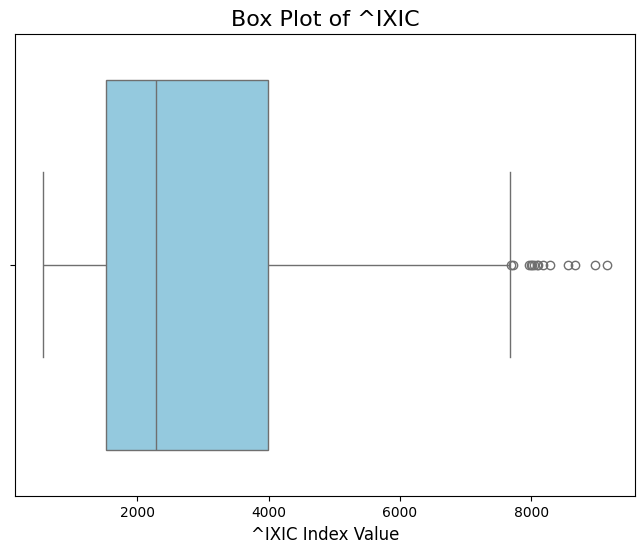

In [38]:
# Create a boxplot of the ^IXIC column data 

# Set plot size
plt.figure(figsize=(8, 6))

# Create a box plot for '^IXIC'
sns.boxplot(x=column, color="skyblue")

# Add title and labels
plt.title("Box Plot of ^IXIC", fontsize=16)
plt.xlabel("^IXIC Index Value", fontsize=12)

# Display the plot
plt.show()

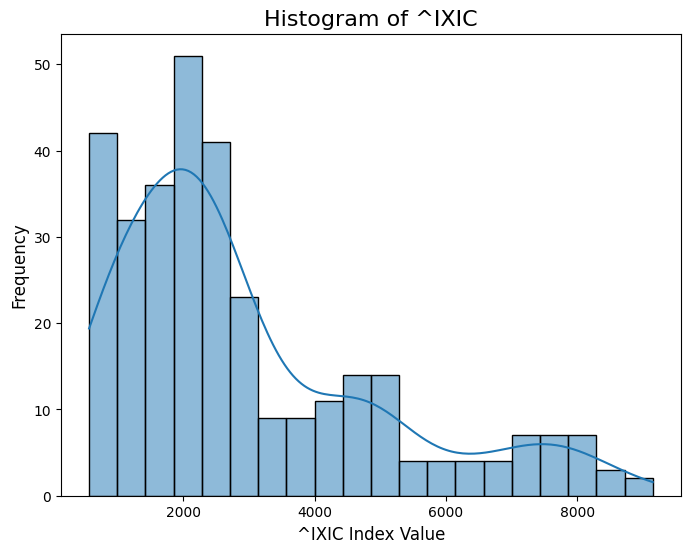

In [39]:
# Create a histogram of the ^IXIC column 

# Set plot size
plt.figure(figsize=(8, 6))

# Create a histogram for '^IXIC'
sns.histplot(column, bins=20, kde=True)

# Add title and labels
plt.title("Histogram of ^IXIC", fontsize=16)
plt.xlabel("^IXIC Index Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Display the plot
plt.show()

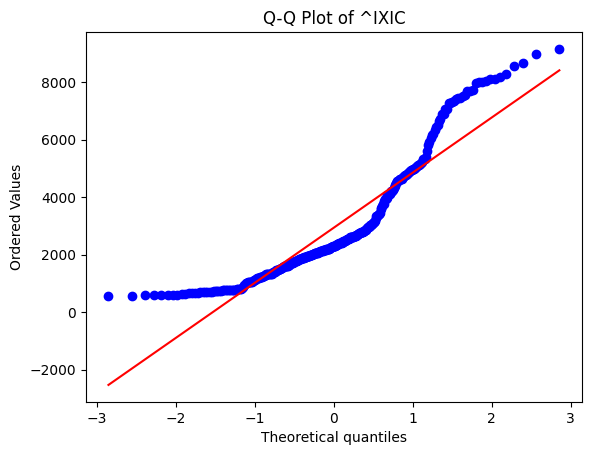

In [40]:
# Create a Q-Q plot for '^IXIC'

# Create Q-Q plot 
stats.probplot(column, dist="norm", plot=plt)

# Add title
plt.title("Q-Q Plot of ^IXIC")

# Display the plot
plt.show()

In [41]:
# Complete the Shapiro-Wilk test for normality 

# Shapiro-Wilk test for normality
stat, p_value = stats.shapiro(column)

# Display the results
print(f"^IXIC Shapiro-Wilk Test Statistic: {stat}")
print(f"^IXIC P-Value: {p_value}")

# Interpretation
alpha = 0.05  # Significance level
if p_value > alpha:
    print("The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")

^IXIC Shapiro-Wilk Test Statistic: 0.8696975111961365
^IXIC P-Value: 6.66872003988626e-16
The data does not follow a normal distribution (reject H0).


# **Answer:** ^IXIC stock index is heavily right-skewed with many outliers. 

# ^DJI Column

In [44]:
# Find all unique values in the ^DJI column 

print(final_dataset2["^DJI"].unique())

[ 3223.4   3267.7   3235.5   3359.1   3396.9   3318.5   3393.8   3257.4
  3271.7   3226.3   3305.2   3301.11  3310.    3370.81  3435.11  3427.55
  3527.43  3516.08  3539.47  3651.25  3555.12  3680.59  3683.95  3754.09
  3978.36  3832.02  3635.96  3681.69  3758.37  3624.96  3764.5   3913.42
  3843.19  3908.12  3739.23  3834.44  3843.86  4011.05  4157.69  4321.27
  4465.14  4556.1   4708.47  4610.56  4789.08  4755.48  5074.49  5117.12
  5395.3   5485.62  5587.14  5569.08  5643.18  5654.63  5528.91  5616.21
  5882.17  6029.38  6521.7   6448.27  6813.09  6877.74  6583.48  7009.
  7331.    7672.8   8222.6   7622.4   7945.3   7442.1   7823.1   7908.3
  7906.5   8545.72  8799.81  9063.37  8899.95  8952.02  8883.29  7539.07
  7842.62  8592.1   9116.55  9181.43  9358.83  9306.58  9786.16 10789.04
 10559.74 10970.8  10655.15 10829.28 10336.95 10729.86 10877.81 11497.12
 10940.53 10128.31 10921.92 10733.91 10522.33 10447.89 10521.98 11215.1
 10650.92 10971.14 10414.49 10787.99 10887.36 10495.28  

In [45]:
# Use the .describe() function to find the descriptive statistics of the ^DJI column 

print("Descriptive Statistics of ^DJI column:\n")

descriptive_statistics = final_dataset2["^DJI"].describe()

display(descriptive_statistics)

Descriptive Statistics of ^DJI column:



count      324.000000
mean     11951.288426
std       6145.747634
min       3223.400000
25%       8180.402500
50%      10734.440000
75%      14961.092500
max      28538.440000
Name: ^DJI, dtype: float64

In [46]:
# Define the pandas DataFrame and ^DJI column 

column = final_dataset2["^DJI"]
column_name = "^DJI"

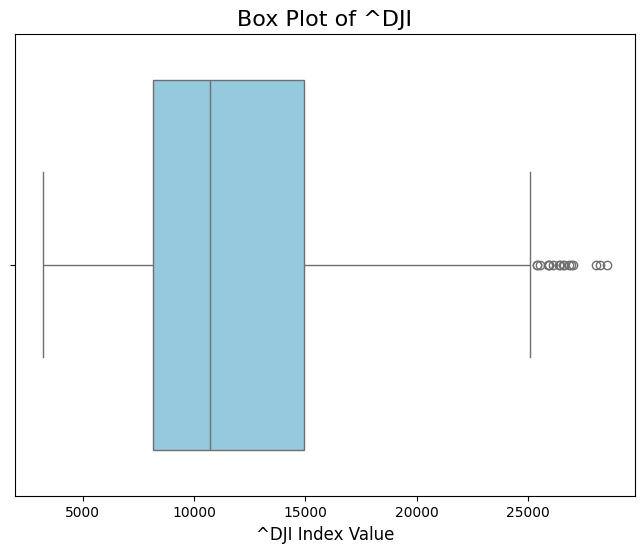

In [47]:
# Create a boxplot of the ^DJI column data 

# Set plot size
plt.figure(figsize=(8, 6))

# Create a box plot for '^DJI'
sns.boxplot(x=column, color="skyblue")

# Add title and labels
plt.title("Box Plot of ^DJI", fontsize=16)
plt.xlabel("^DJI Index Value", fontsize=12)

# Display the plot
plt.show()

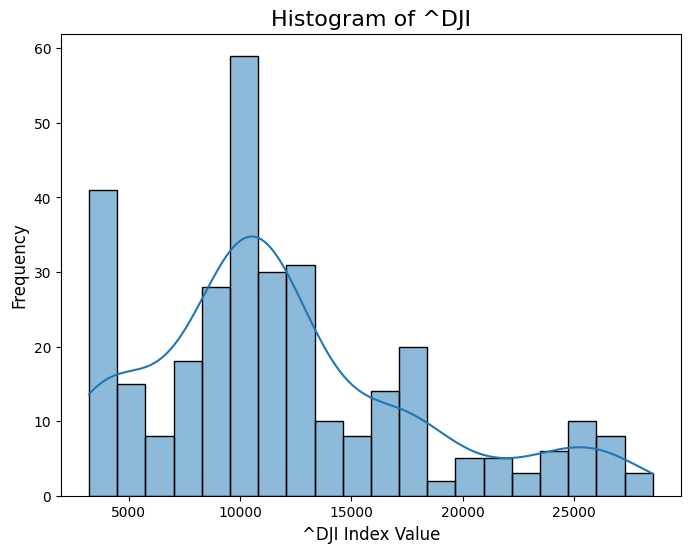

In [48]:
# Create a histogram of the ^DJI column 

# Set plot size
plt.figure(figsize=(8, 6))

# Create a histogram for '^DJI'
sns.histplot(column, bins=20, kde=True)

# Add title and labels
plt.title("Histogram of ^DJI", fontsize=16)
plt.xlabel("^DJI Index Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Display the plot
plt.show()

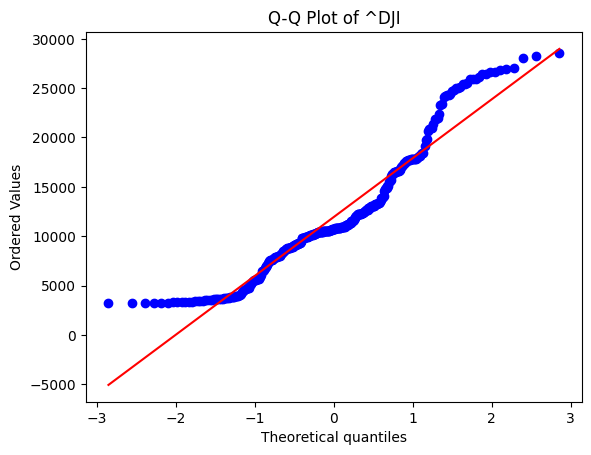

In [49]:
# Create a Q-Q plot for '^DJI'

# Create Q-Q plot 
stats.probplot(column, dist="norm", plot=plt)

# Add title
plt.title("Q-Q Plot of ^DJI")

# Display the plot
plt.show()

In [50]:
# Complete the Shapiro-Wilk test for normality 

# Shapiro-Wilk test for normality
stat, p_value = stats.shapiro(column)

# Display the results
print(f"^DJI Shapiro-Wilk Test Statistic: {stat}")
print(f"^DJI P-Value: {p_value}")

# Interpretation
alpha = 0.05  # Significance level
if p_value > alpha:
    print("The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")

^DJI Shapiro-Wilk Test Statistic: 0.9260273575782776
^DJI P-Value: 1.3921363194169256e-11
The data does not follow a normal distribution (reject H0).


# **Answer:** ^DJI stock index is heavily right-skewed with many outliers.

# Interest_Rate Column

In [53]:
# Find all unique values in the Interest_Rate column 

print(final_dataset2["Interest_Rate"].unique())

[4.03 4.06 3.98 3.73 3.82 3.76 3.25 3.3  3.22 3.1  3.09 2.92 3.02 3.03
 3.07 2.96 3.   3.04 3.06 2.99 3.05 3.34 3.56 4.01 4.25 4.26 4.47 4.73
 4.76 5.29 5.45 5.53 5.92 5.98 6.05 6.01 6.   5.85 5.74 5.8  5.76 5.6
 5.56 5.22 5.31 5.24 5.27 5.4  5.3  5.25 5.19 5.39 5.51 5.5  5.52 5.54
 5.49 5.55 5.07 4.83 4.68 4.63 4.81 4.74 4.99 5.2  5.42 5.73 6.02 6.27
 6.53 6.54 6.5  6.52 6.51 6.4  4.8  4.21 3.97 3.77 3.65 2.49 2.09 1.82
 1.73 1.74 1.75 1.34 1.24 1.26 1.25 1.22 1.01 1.03 1.   0.98 1.43 1.61
 1.76 1.93 2.16 2.28 2.5  2.63 2.79 3.26 3.5  3.62 3.78 4.   4.16 4.29
 4.49 4.59 4.79 4.94 5.26 5.02 4.24 3.94 2.98 2.61 1.98 2.   1.81 0.97
 0.39 0.16 0.15 0.22 0.18 0.2  0.19 0.17 0.14 0.1  0.09 0.07 0.08 0.13
 0.11 0.12 0.24 0.34 0.38 0.36 0.37 0.4  0.41 0.54 0.65 0.66 0.79 0.9
 0.91 1.04 1.15 1.16 1.3  1.41 1.42 1.51 1.69 1.7  1.91 1.95 2.19 2.2
 2.27 2.4  2.41 2.42 2.39 2.38 2.13 2.04 1.83 1.55 1.58]


In [54]:
# Use the .describe() function to find the descriptive statistics of the Interest_Rate column 

print("Descriptive Statistics of Interest_Rate column:\n")

descriptive_statistics = final_dataset2["Interest_Rate"].describe()

display(descriptive_statistics)

Descriptive Statistics of Interest_Rate column:



count    324.000000
mean       2.715370
std        2.140257
min        0.070000
25%        0.400000
50%        2.385000
75%        5.032500
max        6.540000
Name: Interest_Rate, dtype: float64

In [55]:
# Define the pandas DataFrame and Interest_Rate column 

column = final_dataset2["Interest_Rate"]
column_name = "Interest_Rate"

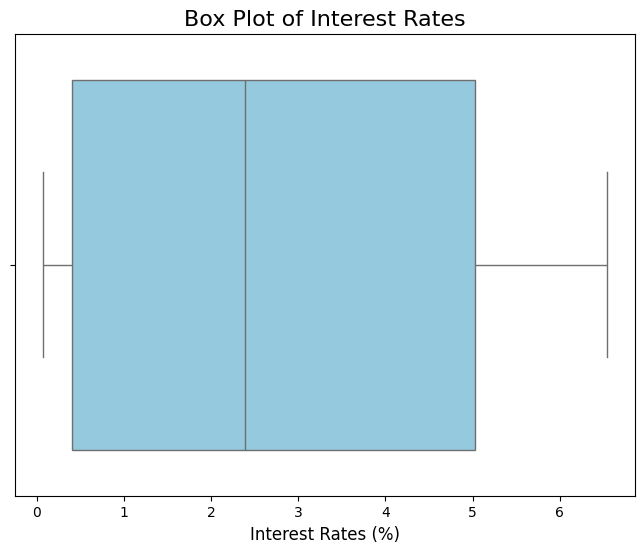

In [56]:
# Create a boxplot of the Interest_Rate column data 

# Set plot size
plt.figure(figsize=(8, 6))

# Create a box plot for 'Interest_Rate'
sns.boxplot(x=column, color="skyblue")

# Add title and labels
plt.title("Box Plot of Interest Rates", fontsize=16)
plt.xlabel("Interest Rates (%)", fontsize=12)

# Display the plot
plt.show()

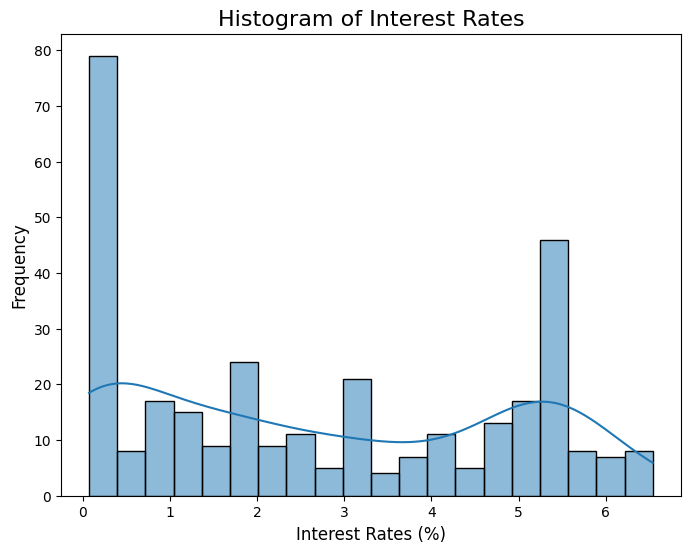

In [57]:
# Create a histogram of the Interest_Rate column 

# Set plot size
plt.figure(figsize=(8, 6))

# Create a histogram for 'Interest_Rate'
sns.histplot(column, bins=20, kde=True)

# Add title and labels
plt.title("Histogram of Interest Rates", fontsize=16)
plt.xlabel("Interest Rates (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Display the plot
plt.show()

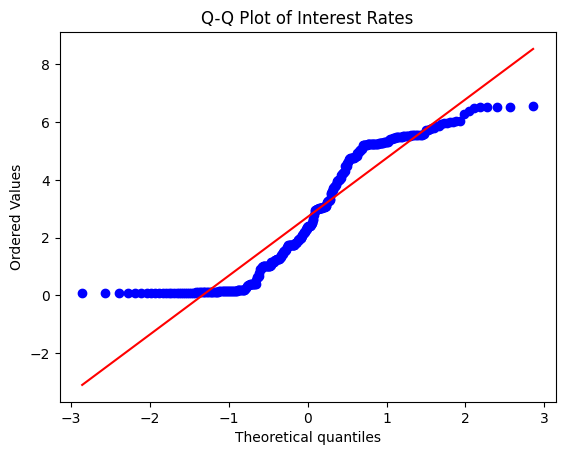

In [58]:
# Create a Q-Q plot for 'Interest_Rate'

# Create Q-Q plot 
stats.probplot(column, dist="norm", plot=plt)

# Add title
plt.title("Q-Q Plot of Interest Rates")

# Display the plot
plt.show()

In [59]:
# Complete the Shapiro-Wilk test for normality 

# Shapiro-Wilk test for normality
stat, p_value = stats.shapiro(column)

# Display the results
print(f"Interest Rate Shapiro-Wilk Test Statistic: {stat}")
print(f"Interest Rate P-Value: {p_value}")

# Interpretation
alpha = 0.05  # Significance level
if p_value > alpha:
    print("The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")

Interest Rate Shapiro-Wilk Test Statistic: 0.8897687792778015
Interest Rate P-Value: 1.5115414752102027e-14
The data does not follow a normal distribution (reject H0).


# **Answer:** Interest Rates are heavily right-skewed with some outliers. 

# Inflation_Rate Column

In [62]:
# Find all unique values in the Inflation_Rate column 

print(final_dataset2["Inflation_Rate"].unique())

[ 2.6  2.8  3.2  3.   3.1  2.9  3.3  2.7  2.5  2.4  2.3  2.2  2.1  1.8
  1.7  1.6  1.4  1.5  2.   3.8  3.7  3.4  3.5  3.6  1.9  1.1  1.2  4.7
  4.3  4.   4.2  4.1  1.3  3.9  5.   5.4  4.9  0.1  0.   0.2 -0.4  1.
  0.8 -0.1 -0.2  0.5  0.7  0.9]


In [63]:
# Use the .describe() function to find the descriptive statistics of the Inflation_Rate column 

print("Descriptive Statistics of Inflation_Rate column:\n")

descriptive_statistics = final_dataset2["Inflation_Rate"].describe()

display(descriptive_statistics)

Descriptive Statistics of Inflation_Rate column:



count    324.000000
mean       2.349691
std        0.976488
min       -0.400000
25%        1.700000
50%        2.400000
75%        3.000000
max        5.400000
Name: Inflation_Rate, dtype: float64

In [64]:
# Define the pandas DataFrame and Inflation_Rate column 

column = final_dataset2["Inflation_Rate"]
column_name = "Inflation_Rate"

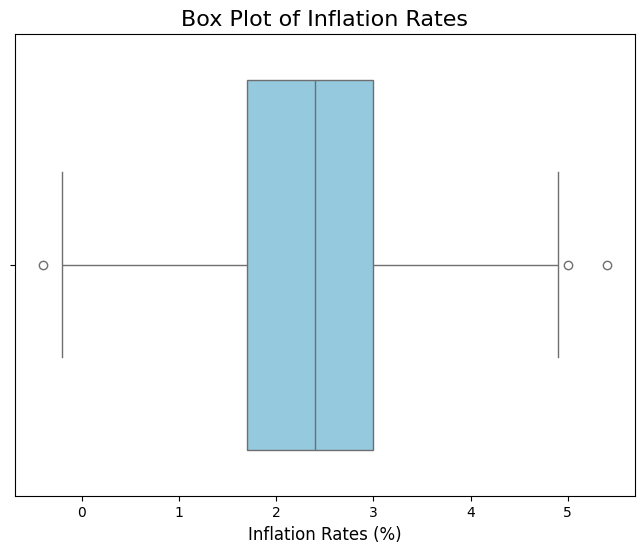

In [65]:
# Create a boxplot of the Inflation_Rate column data 

# Set plot size
plt.figure(figsize=(8, 6))

# Create a box plot for 'Inflation_Rate'
sns.boxplot(x=column, color="skyblue")

# Add title and labels
plt.title("Box Plot of Inflation Rates", fontsize=16)
plt.xlabel("Inflation Rates (%)", fontsize=12)

# Display the plot
plt.show()

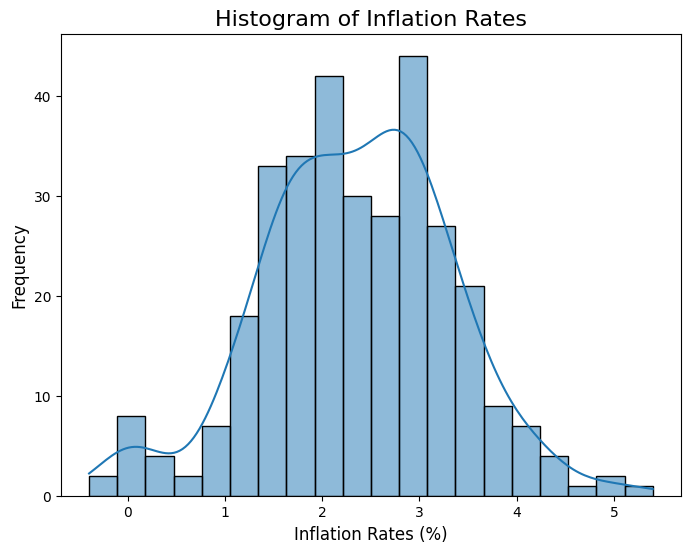

In [66]:
# Create a histogram of the Inflation_Rate column 

# Set plot size
plt.figure(figsize=(8, 6))

# Create a histogram for 'Inflation_Rate'
sns.histplot(column, bins=20, kde=True)

# Add title and labels
plt.title("Histogram of Inflation Rates", fontsize=16)
plt.xlabel("Inflation Rates (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Display the plot
plt.show()

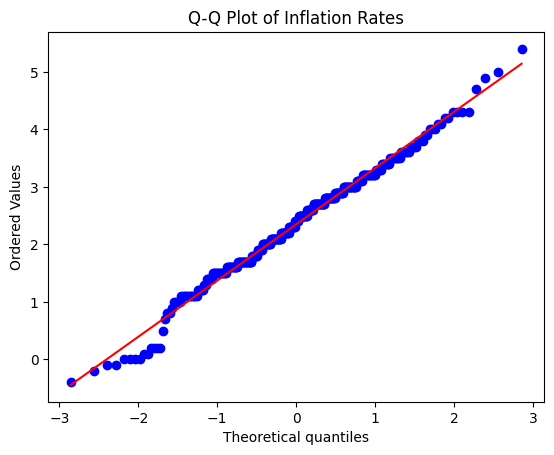

In [67]:
# Create a Q-Q plot for 'Inflation_Rate'

# Create Q-Q plot 
stats.probplot(column, dist="norm", plot=plt)

# Add title
plt.title("Q-Q Plot of Inflation Rates")

# Display the plot
plt.show()

In [68]:
# Complete the Shapiro-Wilk test for normality 

# Shapiro-Wilk test for normality
stat, p_value = stats.shapiro(column)

# Display the results
print(f"Inflation Rate Shapiro-Wilk Test Statistic: {stat}")
print(f"Inflation Rate P-Value: {p_value}")

# Interpretation
alpha = 0.05  # Significance level
if p_value > alpha:
    print("The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")

Inflation Rate Shapiro-Wilk Test Statistic: 0.9902926087379456
Inflation Rate P-Value: 0.030537491664290428
The data does not follow a normal distribution (reject H0).


# **Answer:** Inflation Rates are pretty normally distributed with some outliers. 

# **Bivariate**

# **Question:** How does the unemployment rate correlate with major stock market indices (S&P 500, Nasdaq Composite, and Dow Jones) over time? 

# Unemployment_Rate and ^GSPC Columns

In [73]:
# Calculate Pearson correlation between 'Unemployment_Rate' and '^GSPC'

# Pearson correlation
pearson_corr = final_dataset2["Unemployment_Rate"].corr(final_dataset2["^GSPC"], method="pearson")

# Display the result
print(f"Pearson Correlation: {pearson_corr:.4f}")

# Interpretation
if abs(pearson_corr) < 0.3:
    print("Interpretation: No or weak linear correlation.")
elif 0.3 <= abs(pearson_corr) < 0.7:
    print("Interpretation: Moderate linear correlation.")
else:
    print("Interpretation: Strong linear correlation.")

Pearson Correlation: -0.4355
Interpretation: Moderate linear correlation.


In [74]:
# Perform the Pearson correlation test

# Pearson correlation test
corr_stat, p_value = pearsonr(final_dataset2["Unemployment_Rate"], final_dataset2["^GSPC"])

# Display the correlation statistic and p-value
print(f"Pearson Correlation Coefficient: {corr_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation based on p-value
alpha = 0.05  # significance level

if p_value > alpha:
    print("Fail to reject H0: No significant correlation (correlation = 0).")
else:
    print("Reject H0: Significant correlation exists (correlation != 0).")

Pearson Correlation Coefficient: -0.4355
P-value: 0.0000
Reject H0: Significant correlation exists (correlation != 0).


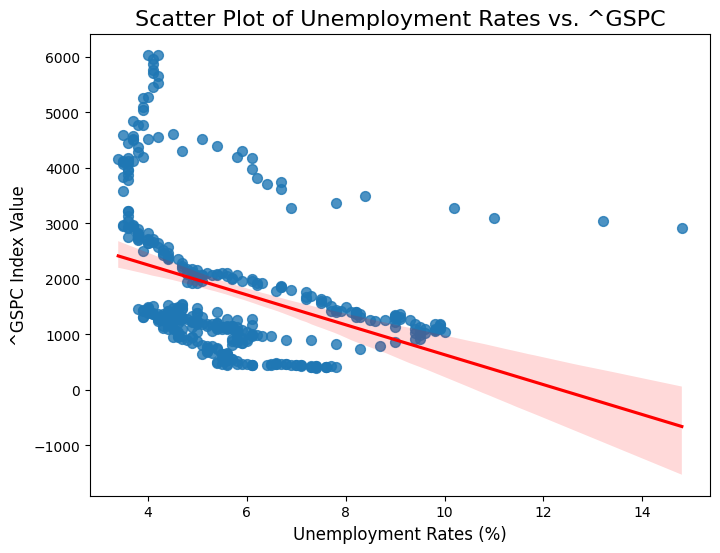

In [75]:
# Create the scatter plot with a regression line using Seaborn

plt.figure(figsize=(8, 6))
sns.regplot(
    x="Unemployment_Rate", 
    y="^GSPC", 
    data=final_dataset, 
    scatter_kws={"s": 50},  # adjust size of scatter points
    line_kws={"color": "red"},  # set line color
)

# Add axis labels and title
plt.xlabel("Unemployment Rates (%)", fontsize=12)
plt.ylabel("^GSPC Index Value", fontsize=12)
plt.title("Scatter Plot of Unemployment Rates vs. ^GSPC", fontsize=16)

# Display the plot
plt.show()

# **Answer:** ^GSPC has a negative correlation with unemployment rates. As unemployment rises, the ^GSPC index value tends to fall. 

# Unemployment_Rate and ^IXIC Columns

In [78]:
# Calculate Pearson correlation between 'Unemployment_Rate' and '^IXIC'

# Pearson correlation
pearson_corr = final_dataset2["Unemployment_Rate"].corr(final_dataset2["^IXIC"], method="pearson")

# Display the result
print(f"Pearson Correlation: {pearson_corr:.4f}")

# Interpretation
if abs(pearson_corr) < 0.3:
    print("Interpretation: No or weak linear correlation.")
elif 0.3 <= abs(pearson_corr) < 0.7:
    print("Interpretation: Moderate linear correlation.")
else:
    print("Interpretation: Strong linear correlation.")

Pearson Correlation: -0.4182
Interpretation: Moderate linear correlation.


In [79]:
# Perform the Pearson correlation test

# Pearson correlation test
corr_stat, p_value = pearsonr(final_dataset2["Unemployment_Rate"], final_dataset2["^IXIC"])

# Display the correlation statistic and p-value
print(f"Pearson Correlation Coefficient: {corr_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation based on p-value
alpha = 0.05  # significance level

if p_value > alpha:
    print("Fail to reject H0: No significant correlation (correlation = 0).")
else:
    print("Reject H0: Significant correlation exists (correlation != 0).")

Pearson Correlation Coefficient: -0.4182
P-value: 0.0000
Reject H0: Significant correlation exists (correlation != 0).


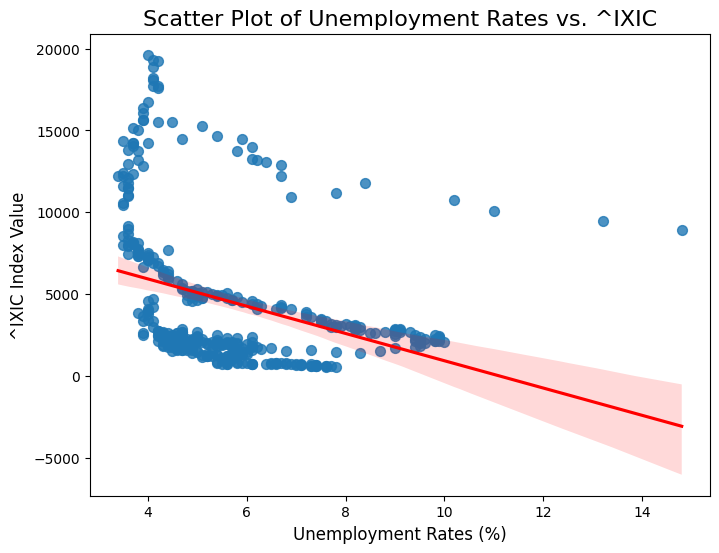

In [80]:
# Create the scatter plot with a regression line using Seaborn

plt.figure(figsize=(8, 6))
sns.regplot(
    x="Unemployment_Rate", 
    y="^IXIC", 
    data=final_dataset, 
    scatter_kws={"s": 50},  # adjust size of scatter points
    line_kws={"color": "red"},  # set line color
)

# Add axis labels and title
plt.xlabel("Unemployment Rates (%)", fontsize=12)
plt.ylabel("^IXIC Index Value", fontsize=12)
plt.title("Scatter Plot of Unemployment Rates vs. ^IXIC", fontsize=16)

# Display the plot
plt.show()

# **Answer:** ^IXIC has a negative correlation with unemployment rates. As unemployment rises, the ^IXIC index value tends to fall. 

# Unemployment_Rate and ^DJI Columns

In [83]:
# Calculate Pearson correlation between 'Unemployment_Rate' and '^DJI'

# Pearson correlation
pearson_corr = final_dataset2["Unemployment_Rate"].corr(final_dataset2["^DJI"], method="pearson")

# Display the result
print(f"Pearson Correlation: {pearson_corr:.4f}")

# Interpretation
if abs(pearson_corr) < 0.3:
    print("Interpretation: No or weak linear correlation.")
elif 0.3 <= abs(pearson_corr) < 0.7:
    print("Interpretation: Moderate linear correlation.")
else:
    print("Interpretation: Strong linear correlation.")

Pearson Correlation: -0.3796
Interpretation: Moderate linear correlation.


In [84]:
# Perform the Pearson correlation test

# Pearson correlation test
corr_stat, p_value = pearsonr(final_dataset2["Unemployment_Rate"], final_dataset2["^DJI"])

# Display the correlation statistic and p-value
print(f"Pearson Correlation Coefficient: {corr_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation based on p-value
alpha = 0.05  # significance level

if p_value > alpha:
    print("Fail to reject H0: No significant correlation (correlation = 0).")
else:
    print("Reject H0: Significant correlation exists (correlation != 0).")

Pearson Correlation Coefficient: -0.3796
P-value: 0.0000
Reject H0: Significant correlation exists (correlation != 0).


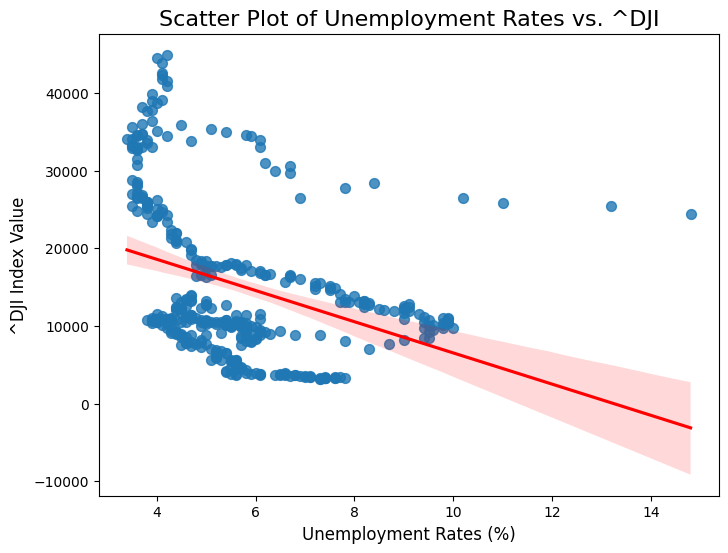

In [85]:
# Create the scatter plot with a regression line using Seaborn

plt.figure(figsize=(8, 6))
sns.regplot(
    x="Unemployment_Rate", 
    y="^DJI", 
    data=final_dataset, 
    scatter_kws={"s": 50},  # adjust size of scatter points
    line_kws={"color": "red"},  # set line color
)

# Add axis labels and title
plt.xlabel("Unemployment Rates (%)", fontsize=12)
plt.ylabel("^DJI Index Value", fontsize=12)
plt.title("Scatter Plot of Unemployment Rates vs. ^DJI", fontsize=16)

# Display the plot
plt.show()

# **Answer:** ^DJI has a negative correlation with unemployment rates. As unemployment rises, the ^DJI index value tends to fall. 

# **Question:** How do stock market trends behave during periods of high vs. low unemployment?

# **Answer:** During periods of high unemployment, all index values tend to drop. During periods of low unemployment, all index values tend to rise. 

# **Question:** How does the unemployment rate correlate with interest rates over time?

# Unemployment_Rate and Interest_Rate Columns

In [91]:
# Calculate Pearson correlation between 'Unemployment_Rate' and 'Interest_Rate'

# Pearson correlation
pearson_corr = final_dataset2["Unemployment_Rate"].corr(final_dataset2["Interest_Rate"], method="pearson")

# Display the result
print(f"Pearson Correlation: {pearson_corr:.4f}")

# Interpretation
if abs(pearson_corr) < 0.3:
    print("Interpretation: No or weak linear correlation.")
elif 0.3 <= abs(pearson_corr) < 0.7:
    print("Interpretation: Moderate linear correlation.")
else:
    print("Interpretation: Strong linear correlation.")

Pearson Correlation: -0.4824
Interpretation: Moderate linear correlation.


In [92]:
# Perform the Pearson correlation test

# Pearson correlation test
corr_stat, p_value = pearsonr(final_dataset2["Unemployment_Rate"], final_dataset2["Interest_Rate"])

# Display the correlation statistic and p-value
print(f"Pearson Correlation Coefficient: {corr_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation based on p-value
alpha = 0.05  # significance level

if p_value > alpha:
    print("Fail to reject H0: No significant correlation (correlation = 0).")
else:
    print("Reject H0: Significant correlation exists (correlation != 0).")

Pearson Correlation Coefficient: -0.4824
P-value: 0.0000
Reject H0: Significant correlation exists (correlation != 0).


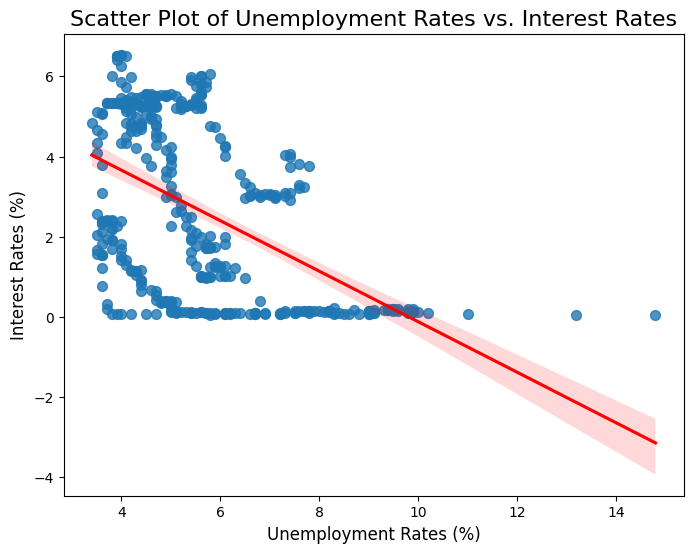

In [93]:
# Create the scatter plot with a regression line using Seaborn

plt.figure(figsize=(8, 6))
sns.regplot(
    x="Unemployment_Rate", 
    y="Interest_Rate", 
    data=final_dataset, 
    scatter_kws={"s": 50},  # adjust size of scatter points
    line_kws={"color": "red"},  # set line color
)

# Add axis labels and title
plt.xlabel("Unemployment Rates (%)", fontsize=12)
plt.ylabel("Interest Rates (%)", fontsize=12)
plt.title("Scatter Plot of Unemployment Rates vs. Interest Rates", fontsize=16)

# Display the plot
plt.show()

# **Answer:** Interest rates have a negative correlation with unemployment rates. As the unemployment rate rises, the interest rate tends to decrease. 

# **Question:** How does the unemployment rate correlate with inflation rates over time?

# Unemployment_Rate and Inflation_Rate Columns

In [97]:
# Calculate Pearson correlation between 'Unemployment_Rate' and 'Inflation_Rate'

# Pearson correlation
pearson_corr = final_dataset2["Unemployment_Rate"].corr(final_dataset2["Inflation_Rate"], method="pearson")

# Display the result
print(f"Pearson Correlation: {pearson_corr:.4f}")

# Interpretation
if abs(pearson_corr) < 0.3:
    print("Interpretation: No or weak linear correlation.")
elif 0.3 <= abs(pearson_corr) < 0.7:
    print("Interpretation: Moderate linear correlation.")
else:
    print("Interpretation: Strong linear correlation.")

Pearson Correlation: -0.0699
Interpretation: No or weak linear correlation.


In [98]:
# Perform the Pearson correlation test

# Pearson correlation test
corr_stat, p_value = pearsonr(final_dataset2["Unemployment_Rate"], final_dataset2["Inflation_Rate"])

# Display the correlation statistic and p-value
print(f"Pearson Correlation Coefficient: {corr_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation based on p-value
alpha = 0.05  # significance level

if p_value > alpha:
    print("Fail to reject H0: No significant correlation (correlation = 0).")
else:
    print("Reject H0: Significant correlation exists (correlation != 0).")

Pearson Correlation Coefficient: -0.0699
P-value: 0.2093
Fail to reject H0: No significant correlation (correlation = 0).


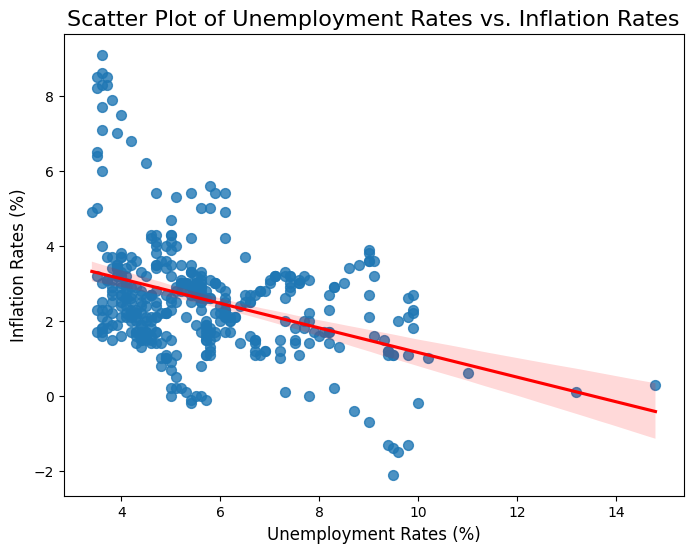

In [99]:
# Create the scatter plot with a regression line using Seaborn

plt.figure(figsize=(8, 6))
sns.regplot(
    x="Unemployment_Rate", 
    y="Inflation_Rate", 
    data=final_dataset, 
    scatter_kws={"s": 50},  # adjust size of scatter points
    line_kws={"color": "red"},  # set line color
)

# Add axis labels and title
plt.xlabel("Unemployment Rates (%)", fontsize=12)
plt.ylabel("Inflation Rates (%)", fontsize=12)
plt.title("Scatter Plot of Unemployment Rates vs. Inflation Rates", fontsize=16)

# Display the plot
plt.show()

# **Answer:** Inflation rates have a negative correlation with unemployment rates. As the unemployment rate rises, the inflation rate tends to decrease. 

# **Question:** How do interest rates correlate with stock indices and inflation rates?

# Interest_Rate and ^GSPC Columns

In [103]:
# Calculate Pearson correlation between 'Interest_Rate' and '^GSPC'

# Pearson correlation
pearson_corr = final_dataset2["Interest_Rate"].corr(final_dataset2["^GSPC"], method="pearson")

# Display the result
print(f"Pearson Correlation: {pearson_corr:.4f}")

# Interpretation
if abs(pearson_corr) < 0.3:
    print("Interpretation: No or weak linear correlation.")
elif 0.3 <= abs(pearson_corr) < 0.7:
    print("Interpretation: Moderate linear correlation.")
else:
    print("Interpretation: Strong linear correlation.")

Pearson Correlation: -0.4226
Interpretation: Moderate linear correlation.


In [104]:
# Perform the Pearson correlation test

# Pearson correlation test
corr_stat, p_value = pearsonr(final_dataset2["Interest_Rate"], final_dataset2["^GSPC"])

# Display the correlation statistic and p-value
print(f"Pearson Correlation Coefficient: {corr_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation based on p-value
alpha = 0.05  # significance level

if p_value > alpha:
    print("Fail to reject H0: No significant correlation (correlation = 0).")
else:
    print("Reject H0: Significant correlation exists (correlation != 0).")

Pearson Correlation Coefficient: -0.4226
P-value: 0.0000
Reject H0: Significant correlation exists (correlation != 0).


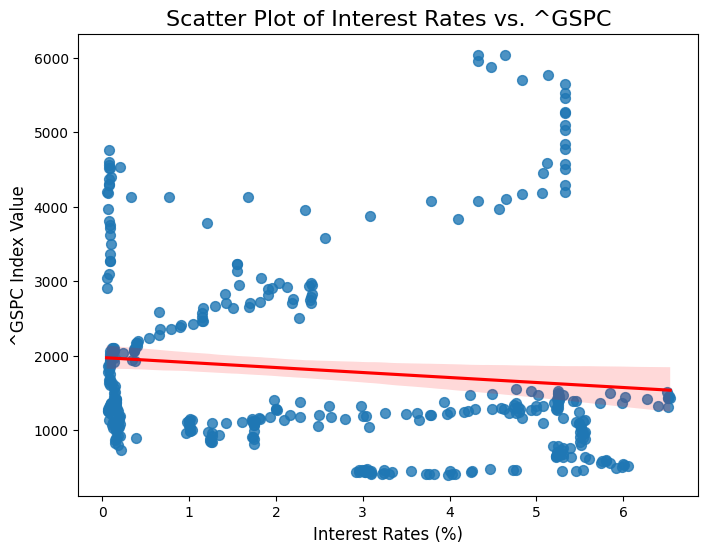

In [105]:
# Create the scatter plot with a regression line using Seaborn

plt.figure(figsize=(8, 6))
sns.regplot(
    x="Interest_Rate", 
    y="^GSPC", 
    data=final_dataset, 
    scatter_kws={"s": 50},  # adjust size of scatter points
    line_kws={"color": "red"},  # set line color
)

# Add axis labels and title
plt.xlabel("Interest Rates (%)", fontsize=12)
plt.ylabel("^GSPC Index Value", fontsize=12)
plt.title("Scatter Plot of Interest Rates vs. ^GSPC", fontsize=16)

# Display the plot
plt.show()

# **Answer:** ^GSPC index has a negative correlation with interest rates. As interest rates rise, the ^GSPC index value tends to decrease.

# Interest_Rate and ^IXIC Columns

In [108]:
# Calculate Pearson correlation between 'Interest_Rate' and '^IXIC'

# Pearson correlation
pearson_corr = final_dataset2["Interest_Rate"].corr(final_dataset2["^IXIC"], method="pearson")

# Display the result
print(f"Pearson Correlation: {pearson_corr:.4f}")

# Interpretation
if abs(pearson_corr) < 0.3:
    print("Interpretation: No or weak linear correlation.")
elif 0.3 <= abs(pearson_corr) < 0.7:
    print("Interpretation: Moderate linear correlation.")
else:
    print("Interpretation: Strong linear correlation.")

Pearson Correlation: -0.3992
Interpretation: Moderate linear correlation.


In [109]:
# Perform the Pearson correlation test

# Pearson correlation test
corr_stat, p_value = pearsonr(final_dataset2["Interest_Rate"], final_dataset2["^IXIC"])

# Display the correlation statistic and p-value
print(f"Pearson Correlation Coefficient: {corr_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation based on p-value
alpha = 0.05  # significance level

if p_value > alpha:
    print("Fail to reject H0: No significant correlation (correlation = 0).")
else:
    print("Reject H0: Significant correlation exists (correlation != 0).")

Pearson Correlation Coefficient: -0.3992
P-value: 0.0000
Reject H0: Significant correlation exists (correlation != 0).


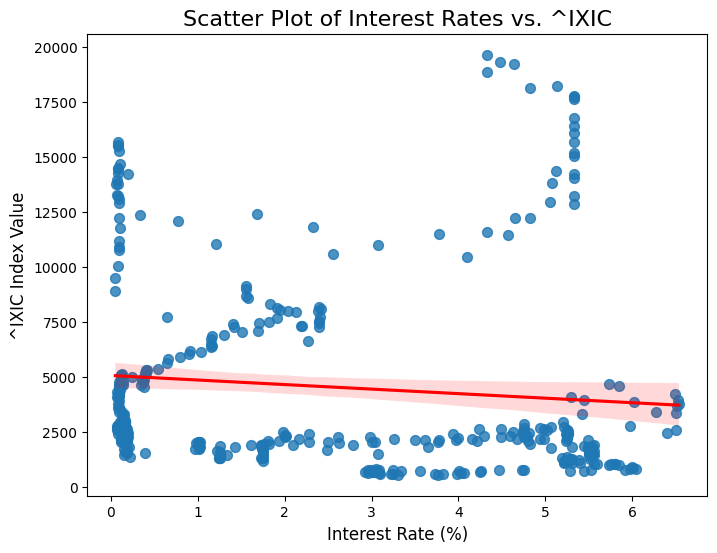

In [110]:
# Create the scatter plot with a regression line using Seaborn

plt.figure(figsize=(8, 6))
sns.regplot(
    x="Interest_Rate", 
    y="^IXIC", 
    data=final_dataset, 
    scatter_kws={"s": 50},  # adjust size of scatter points
    line_kws={"color": "red"},  # set line color
)

# Add axis labels and title
plt.xlabel("Interest Rate (%)", fontsize=12)
plt.ylabel("^IXIC Index Value", fontsize=12)
plt.title("Scatter Plot of Interest Rates vs. ^IXIC", fontsize=16)

# Display the plot
plt.show()

# **Answer:** ^IXIC index has a negative correlation with interest rates. As interest rates rise, the ^IXIC index value tends to decrease. 

# Interest_Rate and ^DJI Columns 

In [113]:
# Calculate Pearson correlation between 'Interest_Rate' and '^DJI'

# Pearson correlation
pearson_corr = final_dataset2["Interest_Rate"].corr(final_dataset2["^DJI"], method="pearson")

# Display the result
print(f"Pearson Correlation: {pearson_corr:.4f}")

# Interpretation
if abs(pearson_corr) < 0.3:
    print("Interpretation: No or weak linear correlation.")
elif 0.3 <= abs(pearson_corr) < 0.7:
    print("Interpretation: Moderate linear correlation.")
else:
    print("Interpretation: Strong linear correlation.")

Pearson Correlation: -0.4736
Interpretation: Moderate linear correlation.


In [114]:
# Perform the Pearson correlation test

# Pearson correlation test
corr_stat, p_value = pearsonr(final_dataset2["Interest_Rate"], final_dataset2["^DJI"])

# Display the correlation statistic and p-value
print(f"Pearson Correlation Coefficient: {corr_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation based on p-value
alpha = 0.05  # significance level

if p_value > alpha:
    print("Fail to reject H0: No significant correlation (correlation = 0).")
else:
    print("Reject H0: Significant correlation exists (correlation != 0).")

Pearson Correlation Coefficient: -0.4736
P-value: 0.0000
Reject H0: Significant correlation exists (correlation != 0).


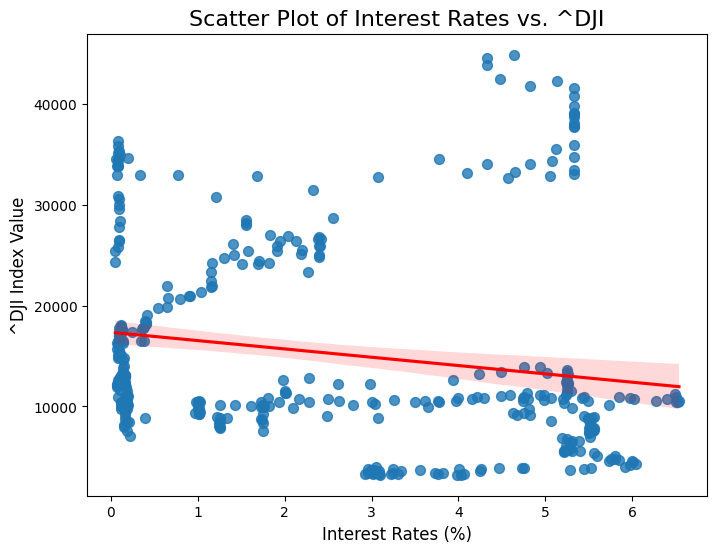

In [115]:
# Create the scatter plot with a regression line using Seaborn

plt.figure(figsize=(8, 6))
sns.regplot(
    x="Interest_Rate", 
    y="^DJI", 
    data=final_dataset, 
    scatter_kws={"s": 50},  # adjust size of scatter points
    line_kws={"color": "red"},  # set line color
)

# Add axis labels and title
plt.xlabel("Interest Rates (%)", fontsize=12)
plt.ylabel("^DJI Index Value", fontsize=12)
plt.title("Scatter Plot of Interest Rates vs. ^DJI", fontsize=16)

# Display the plot
plt.show()

# **Answer:** ^DJI index has a negative correlation with interest rates. As interest rates rise, the ^DJI index value tends to decrease. 

# Interest_Rate and Inflation_Rate Columns 

In [118]:
# Calculate Pearson correlation between 'Interest_Rate' and 'Inflation_Rate'

# Pearson correlation
pearson_corr = final_dataset2["Interest_Rate"].corr(final_dataset2["Inflation_Rate"], method="pearson")

# Display the result
print(f"Pearson Correlation: {pearson_corr:.4f}")

# Interpretation
if abs(pearson_corr) < 0.3:
    print("Interpretation: No or weak linear correlation.")
elif 0.3 <= abs(pearson_corr) < 0.7:
    print("Interpretation: Moderate linear correlation.")
else:
    print("Interpretation: Strong linear correlation.")

Pearson Correlation: 0.4534
Interpretation: Moderate linear correlation.


In [119]:
# Perform the Pearson correlation test

# Pearson correlation test
corr_stat, p_value = pearsonr(final_dataset2["Interest_Rate"], final_dataset2["^DJI"])

# Display the correlation statistic and p-value
print(f"Pearson Correlation Coefficient: {corr_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation based on p-value
alpha = 0.05  # significance level

if p_value > alpha:
    print("Fail to reject H0: No significant correlation (correlation = 0).")
else:
    print("Reject H0: Significant correlation exists (correlation != 0).")

Pearson Correlation Coefficient: -0.4736
P-value: 0.0000
Reject H0: Significant correlation exists (correlation != 0).


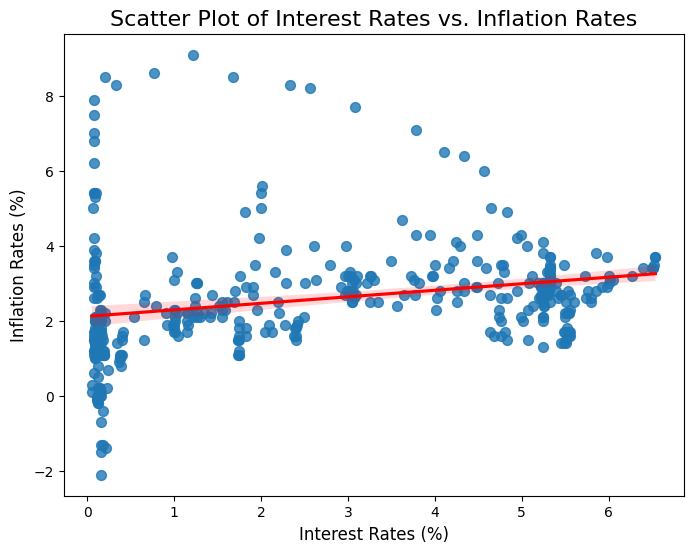

In [120]:
# Create the scatter plot with a regression line using Seaborn

plt.figure(figsize=(8, 6))
sns.regplot(
    x="Interest_Rate", 
    y="Inflation_Rate", 
    data=final_dataset, 
    scatter_kws={"s": 50},  # adjust size of scatter points
    line_kws={"color": "red"},  # set line color
)

# Add axis labels and title
plt.xlabel("Interest Rates (%)", fontsize=12)
plt.ylabel("Inflation Rates (%)", fontsize=12)
plt.title("Scatter Plot of Interest Rates vs. Inflation Rates", fontsize=16)

# Display the plot
plt.show()

# **Answer:** Inflation rates have a positive correlation with interest rates. As interest rates rise, the inflation rate also rises. 

# Hypothesis Test

# Two-Sample T-Tests

# Grouping dates into decades to compare unemployment across decades. 

# **Question:** Is there a notable difference in unemployment from decade to decade? 

# Comparing Unemployment Rates From the 1990s to the 2000s

In [127]:
# Convert to datetime format 
final_dataset['Date'] = pd.to_datetime(final_dataset['Date'])

# Create a new column for decade
final_dataset['Decade'] = (final_dataset['Date'].dt.year // 10) * 10

# Filter for two decades (1990s and 2000s)
unemployment_1990s = final_dataset[final_dataset['Decade'] == 1990]['Unemployment_Rate']
unemployment_2000s = final_dataset[final_dataset['Decade'] == 2000]['Unemployment_Rate']

# Run a two-sample t-test
t_stat, p_value = ttest_ind(unemployment_1990s, unemployment_2000s, equal_var=False)  

# Show results for t-statistic and p-value
print("T-Statistic:", t_stat)
print("P-value:", p_value)

# Interpret the results according to alpha 
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Average unemployment is significantly different between the 1990s and 2000s.")
else:
    print("Fail to reject the null hypothesis: No significant difference in average unemployment the 1990s and 2000s.")

T-Statistic: 0.5968223622548725
P-value: 0.5512589310147289
Fail to reject the null hypothesis: No significant difference in average unemployment the 1990s and 2000s.


# **Answer:** From the 1990s to the 2000s, there is not a signficiant difference in average unemployment. 

# Comparing Unemployment Rates From the 2000s to the 2010s

In [130]:
# Create a new column for decade
final_dataset['Decade'] = (final_dataset['Date'].dt.year // 10) * 10

# Filter for two decades (2000s and 2010s)
unemployment_2000s = final_dataset[final_dataset['Decade'] == 2000]['Unemployment_Rate']
unemployment_2010s = final_dataset[final_dataset['Decade'] == 2010]['Unemployment_Rate']

# Run a two-sample t-test
t_stat, p_value = ttest_ind(unemployment_2000s, unemployment_2010s, equal_var=False)  

# Show results for t-statistic and p-value
print("T-Statistic:", t_stat)
print("P-value:", p_value)

# Interpret the results according to alpha 
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Average unemployment is significantly different between the 2000s and 2010s.")
else:
    print("Fail to reject the null hypothesis: No significant difference in average unemployment the 2000s and 2010s.")

T-Statistic: -2.9539201415970164
P-value: 0.0034895472773083087
Reject the null hypothesis: Average unemployment is significantly different between the 2000s and 2010s.


# **Answer:** From the 2000s to the 2010s, there is a signficant difference in average unemployment. 

# Comparing Unemployment Rates From the 2010s to the 2020s

In [133]:
# Create a new column for decade
final_dataset['Decade'] = (final_dataset['Date'].dt.year // 10) * 10

# Filter for two decades (2010s and 2020s)
unemployment_2010s = final_dataset[final_dataset['Decade'] == 2010]['Unemployment_Rate']
unemployment_2020s = final_dataset[final_dataset['Decade'] == 2020]['Unemployment_Rate']

# Run a two-sample t-test
t_stat, p_value = ttest_ind(unemployment_2010s, unemployment_2020s, equal_var=False)  

# Show results for t-statistic and p-value
print("T-Statistic:", t_stat)
print("P-value:", p_value)

# Interpret the results according to alpha 
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Average unemployment is significantly different between the 2010s and 2020s.")
else:
    print("Fail to reject the null hypothesis: No significant difference in average unemployment the 2010s and 2020s.")

T-Statistic: 3.713109331140444
P-value: 0.00032130067329581353
Reject the null hypothesis: Average unemployment is significantly different between the 2010s and 2020s.


# **Answer:** From the 2010s to the 2020s, there is a significant difference in average unemployment. 

# **Machine Learning** 

# Target variable: unemployment rate or a categorical variable of unemployment rate

# **Question:** Which machine learning model is the best fit for my data? 

# Linear Regression Model

In [139]:
# Find the target and predictor variables 

# Predictor variables 
X = final_dataset.drop(['Unemployment_Rate', 'Date'], axis=1)

# Target variable 
y = final_dataset['Unemployment_Rate'].values 

In [140]:
# Linear Regression Model 

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42) 

Lin_Reg = LinearRegression()

# Fit the training data to the Linear Regression 
Lin_Reg.fit(X_train, y_train)

# Get the predictions 
y_pred = Lin_Reg.predict(X_test)

# Prediction is a straight line: y = ax + b 
# R^2 score - model not working well - very low - not good for making predictions on this pandas DataFrame 
print(f'Linear Regression R^2: {Lin_Reg.score(X_test, y_test)}')

Linear Regression R^2: 0.6783667055712629


In [141]:
# Linear Regression y-intercept 

intercept = Lin_Reg.intercept_
print(f'Linear Regression intercept: {intercept}')

Linear Regression intercept: -318.11978205660967


In [142]:
# Coefficients of the Linear Regression 

# Many coefficients because each column has a coefficient 
print(f'Linear Regression coefficients: {Lin_Reg.coef_}')

Linear Regression coefficients: [-0.00268584  0.00103966 -0.00032919 -0.2413405  -0.19965323  0.1647241 ]


In [143]:
# Step 13 - Print the columns of final_dataset pandas DataFrame 

print(f'Allstate columns: {final_dataset.columns}')

Allstate columns: Index(['Date', 'Unemployment_Rate', '^GSPC', '^IXIC', '^DJI', 'Interest_Rate',
       'Inflation_Rate', 'Decade'],
      dtype='object')


# Decision Tree Classifier Model

In [145]:
# Convert the Unemployment_Rate column to Unemployment_Group indicating the level of unemployment 

final_dataset["Unemployment_Group"] = pd.qcut(final_dataset["Unemployment_Rate"], q=4, labels=["Very Low", "Low", "High", "Very High"])

In [146]:
# Find the target and predictor variables 

X = final_dataset.drop(columns=["Unemployment_Rate", "Unemployment_Group", "Date", "Decade"])
y = final_dataset["Unemployment_Group"]

In [147]:
# Decision Tree Classifier Model 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dec_tree = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
Dec_tree.fit(X_train, y_train)

# Get the predictions
y_pred = Dec_tree.predict(X_test)

# Print Accuracy Score
print(f'Decision Tree Accuracy: {Dec_tree.score(X_test,y_test)}')

# Print F1_score 
print(f"Decision Tree F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

Decision Tree Accuracy: 0.8875
Decision Tree F1 Score: 0.8848


# Support Vector Classifier Model 

In [149]:
# Support Vector Classifier Model 

svm = SVC()

# Fit the classifier to the training data 
svm.fit(X_train, y_train)

# Get the predictions 
y_pred = svm.predict(X_test)

# Print Accuracy Score 
print(f'SVC Accuracy: {svm.score(X_test, y_test)}')

# Print F1 Score 
print(f"SVC F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

SVC Accuracy: 0.5125
SVC F1 Score: 0.4614


# K-Nearest Neighbors Classifier Model

In [151]:
# KNN Classifier Model

knn = KNeighborsClassifier(n_neighbors=7)

# Fit the training data to the model
knn.fit(X_train, y_train)

# Get the predictions 
y_pred = knn.predict(X_test)

# Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[16,  3,  0,  1],
       [ 7, 17,  0,  0],
       [ 2,  1, 13,  0],
       [ 0,  0,  1, 19]])

In [152]:
# Classification Report 

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.64      0.80      0.71        20
         Low       0.81      0.71      0.76        24
   Very High       0.93      0.81      0.87        16
    Very Low       0.95      0.95      0.95        20

    accuracy                           0.81        80
   macro avg       0.83      0.82      0.82        80
weighted avg       0.83      0.81      0.82        80



In [153]:
# Print results 

# Print Accuracy Score 
print(f'KNN Accuracy: {knn.score(X_test, y_test)}')

# Print F1 Score
print(f"KNN F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

KNN Accuracy: 0.8125
KNN F1 Score: 0.8153


# Logistic Regression Model

In [155]:
# Logistic Regression Model

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ensuring no warnings appear in output with this classifier 
final_log = LogisticRegression(solver='liblinear', max_iter=4000, class_weight='balanced')

# Fit the training data to the Logistic Regression model 
final_log.fit(X_train,y_train)

# Get the predictions 
y_pred = final_log.predict(X_test)

# Print the Accuracy Score 
print(f"Logistic Regression Accuracy: {final_log.score(X_test, y_test)}")

# Print the F1 Score
print(f"Logistic Regression F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

Logistic Regression Accuracy: 0.6375
Logistic Regression F1 Score: 0.6240


# **Answer:** The Decision Tree Classifier Model fits my data the best with an accuracy score of .8875. 

# **More analysis questions**

# **Question:** Which stock market index (S&P 500, Nasdaq Composite, Dow Jones) is most sensitive to changes in unemployment rates?

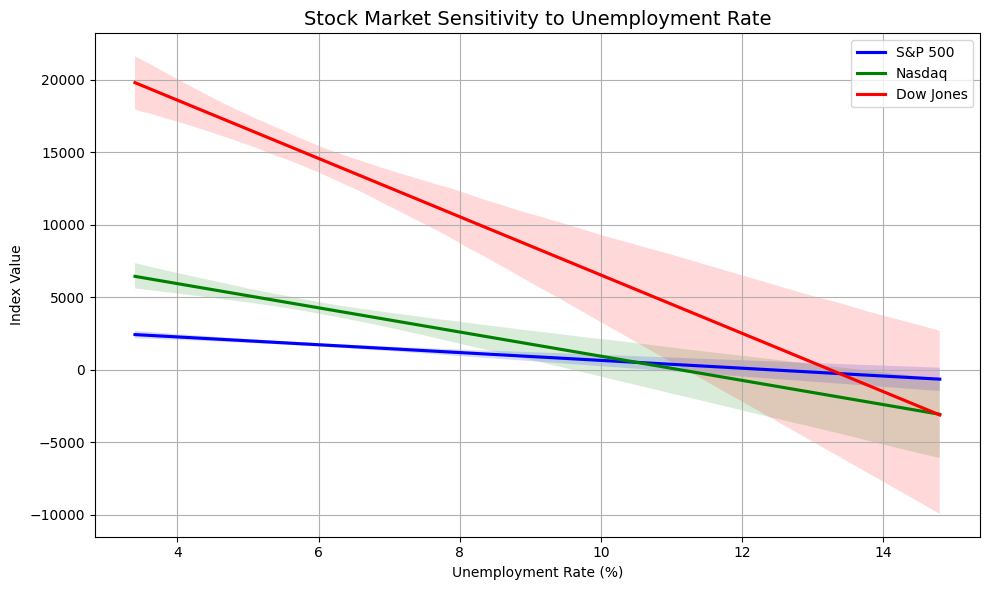

In [159]:
# Create a combined regression plot with all stocks and unemployment rate 

plt.figure(figsize=(10, 6))

# Plot S&P 500
sns.regplot(x=final_dataset['Unemployment_Rate'], y=final_dataset['^GSPC'],
            scatter=False, label='S&P 500', color='blue')

# Plot Nasdaq
sns.regplot(x=final_dataset['Unemployment_Rate'], y=final_dataset['^IXIC'],
            scatter=False, label='Nasdaq', color='green')

# Plot Dow Jones
sns.regplot(x=final_dataset['Unemployment_Rate'], y=final_dataset['^DJI'],
            scatter=False, label='Dow Jones', color='red')

# Add titles and labels
plt.title('Stock Market Sensitivity to Unemployment Rate', fontsize=14)
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [160]:
# Find the slope of the regression lines 

indexes = {
    'S&P 500': '^GSPC',
    'Nasdaq': '^IXIC',
    'Dow Jones': '^DJI'
}

for name, col in indexes.items():
    X = sm.add_constant(final_dataset['Unemployment_Rate'])  # adds intercept term
    y = final_dataset[col]
    model = sm.OLS(y, X).fit()
    slope = model.params.iloc[1]
    r2 = model.rsquared
    print(f"{name}: Slope = {slope:.2f}, R² = {r2:.3f}")

S&P 500: Slope = -269.64, R² = 0.141
Nasdaq: Slope = -834.02, R² = 0.112
Dow Jones: Slope = -2009.59, R² = 0.130


# **Answer:** Dow Jones Index is the most sensitive to changes in the unemployment rate.

# **Question:** Does the stock market decline before or after an increase in unemployment rates?

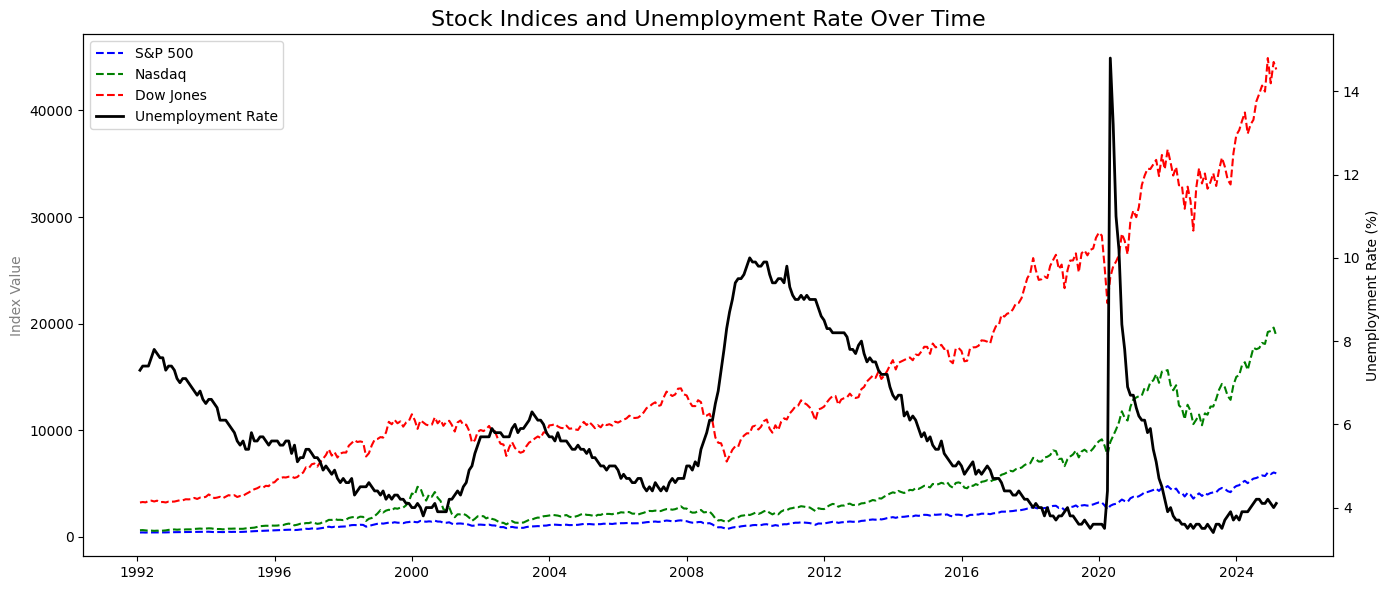

In [163]:
# Plot the figure 
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot unemployment rate on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(final_dataset['Date'], final_dataset['Unemployment_Rate'], color='black', label='Unemployment Rate', linewidth=2)
ax2.set_ylabel('Unemployment Rate (%)', color='black')

# Plot indices on primary axis
ax1.plot(final_dataset['Date'], final_dataset['^GSPC'], label='S&P 500', color='blue', linestyle='--')
ax1.plot(final_dataset['Date'], final_dataset['^IXIC'], label='Nasdaq', color='green', linestyle='--')
ax1.plot(final_dataset['Date'], final_dataset['^DJI'], label='Dow Jones', color='red', linestyle='--')
ax1.set_ylabel('Index Value', color='gray')

# Title, legend, etc.
plt.title('Stock Indices and Unemployment Rate Over Time', fontsize=16)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()

In [164]:
# Calculate lagged correlation
lagged_corr_gspc = final_dataset['^GSPC'].corr(final_dataset['Unemployment_Rate'].shift(1))  # 1-period lag
lagged_corr_ixic = final_dataset['^IXIC'].corr(final_dataset['Unemployment_Rate'].shift(1))
lagged_corr_dji = final_dataset['^DJI'].corr(final_dataset['Unemployment_Rate'].shift(1))

print(f'GSPC Lagged Correlation: {lagged_corr_gspc}')
print(f'IXIC Lagged Correlation: {lagged_corr_ixic}')
print(f'DJI Lagged Correlation: {lagged_corr_dji}')

GSPC Lagged Correlation: -0.36663158256122164
IXIC Lagged Correlation: -0.32437581501652596
DJI Lagged Correlation: -0.3521339593053846


# **Answer:** The stock market index values tend to decrease when unemployment rates increase. The stock market prices start to decrease right when the unemployment rate increases. 

# **Answer:** When the stock index declines, the unemployment rate tends to increase. With the stocks' negative lagged correlations, these numbers represent a moderate to weak negative relationship with unemployment. The relationship is not perfect, but when stock indexes decrease in price, the unemployment rate tends to increase. 

# **Question:** Does a rising inflation rate weaken the stock market more than an increasing unemployment rate?

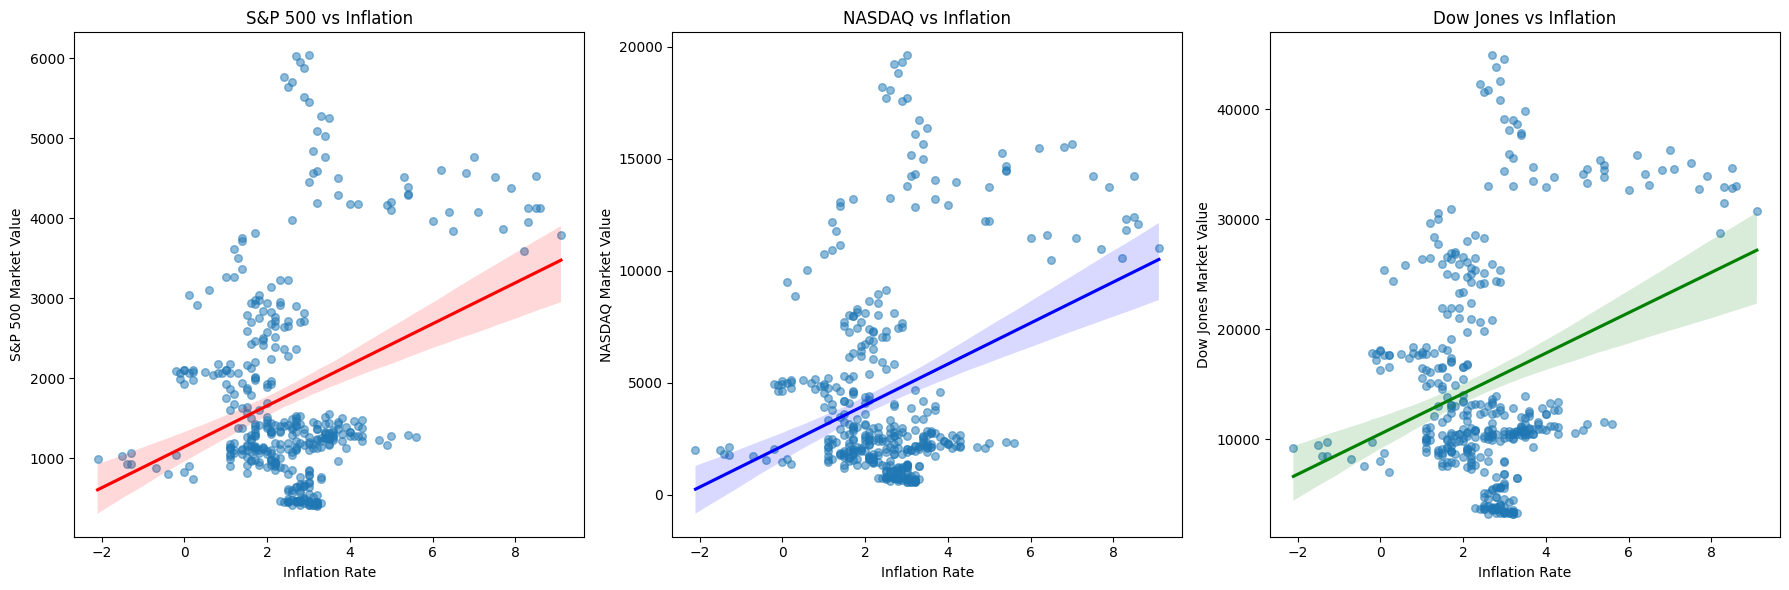

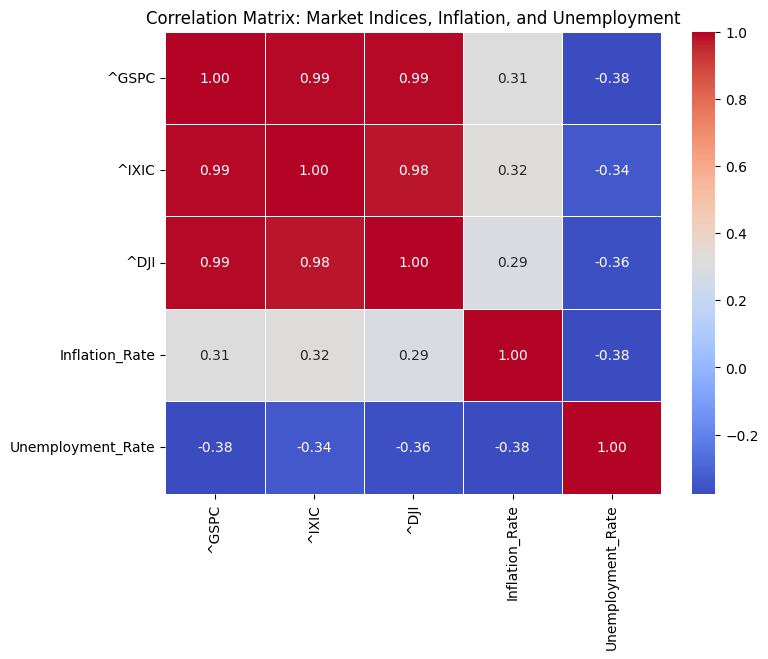

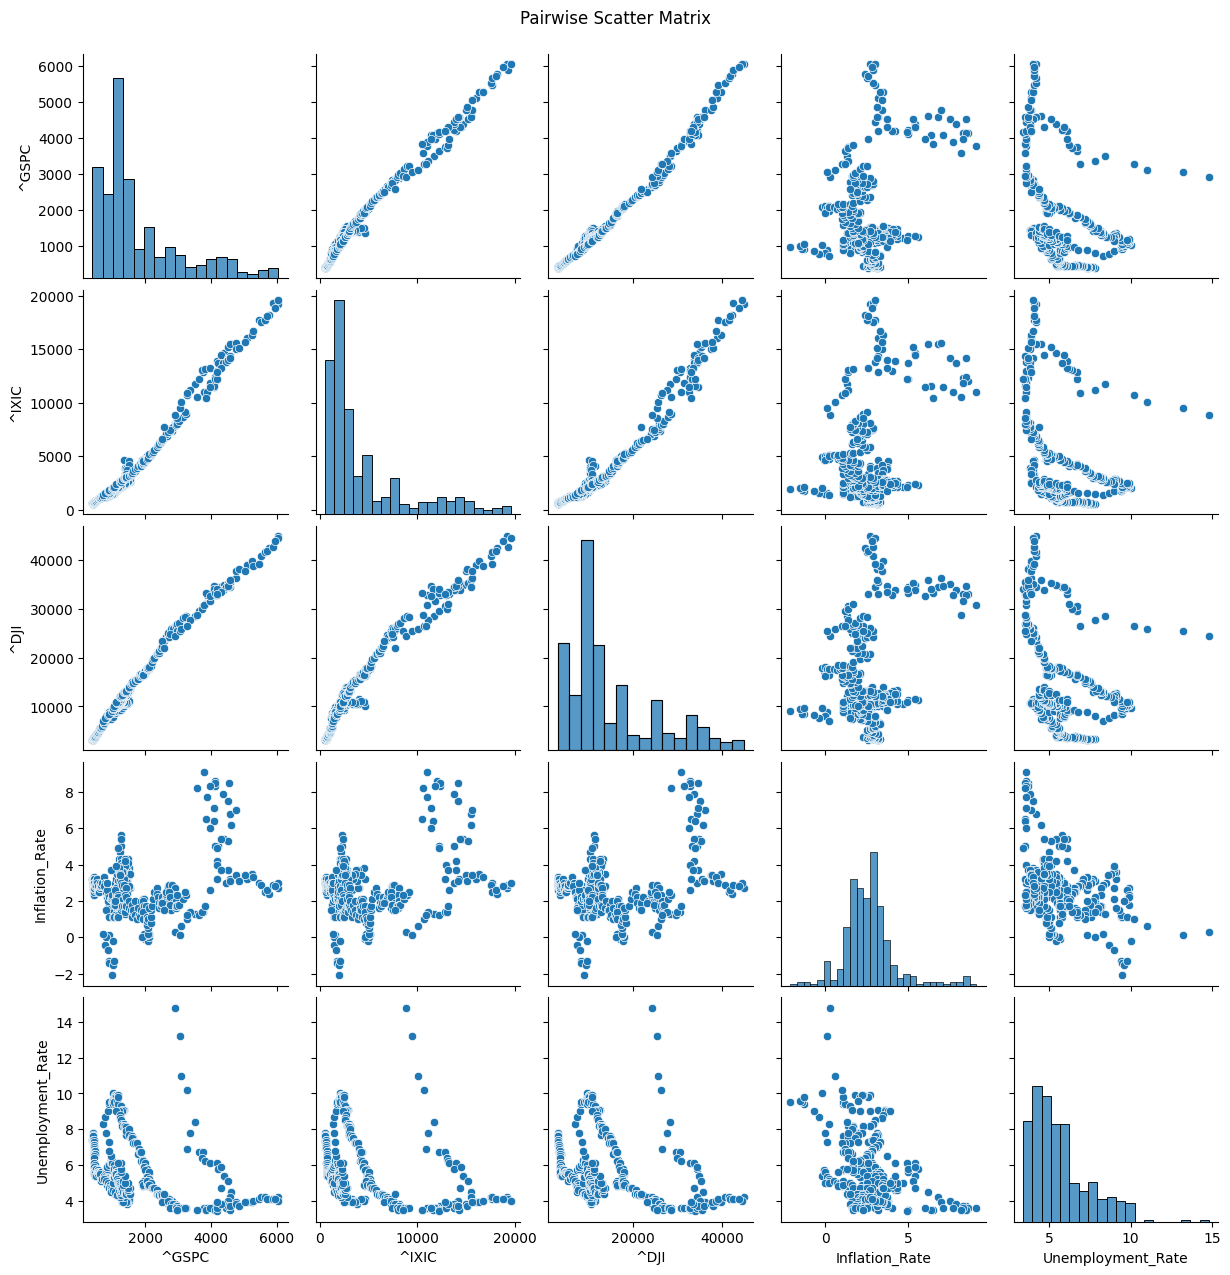

Correlation between S&P 500 and Inflation: 0.31
Correlation between NASDAQ and Inflation: 0.32
Correlation between Dow Jones and Inflation: 0.29
Correlation between S&P 500 and Unemployment: -0.38
Correlation between NASDAQ and Unemployment: -0.34
Correlation between Dow Jones and Unemployment: -0.36


In [168]:
# Scatter plot for each market index vs. Inflation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# S&P vs Inflation
sns.regplot(x='Inflation_Rate', y='^GSPC', data=final_dataset, scatter_kws={'s': 30, 'alpha': 0.5}, line_kws={'color': 'red'}, ax=axes[0])
axes[0].set_title('S&P 500 vs Inflation')
axes[0].set_xlabel('Inflation Rate')
axes[0].set_ylabel('S&P 500 Market Value')

# NASDAQ vs Inflation
sns.regplot(x='Inflation_Rate', y='^IXIC', data=final_dataset, scatter_kws={'s': 30, 'alpha': 0.5}, line_kws={'color': 'blue'}, ax=axes[1])
axes[1].set_title('NASDAQ vs Inflation')
axes[1].set_xlabel('Inflation Rate')
axes[1].set_ylabel('NASDAQ Market Value')

# Dow Jones vs Inflation
sns.regplot(x='Inflation_Rate', y='^DJI', data=final_dataset, scatter_kws={'s': 30, 'alpha': 0.5}, line_kws={'color': 'green'}, ax=axes[2])
axes[2].set_title('Dow Jones vs Inflation')
axes[2].set_xlabel('Inflation Rate')
axes[2].set_ylabel('Dow Jones Market Value')

plt.tight_layout()
plt.show()

# Correlation matrix to compare all market indices with inflation and unemployment
corr_matrix = final_dataset[['^GSPC', '^IXIC', '^DJI', 'Inflation_Rate', 'Unemployment_Rate']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix: Market Indices, Inflation, and Unemployment')
plt.show()

# Pairwise scatter matrix for all market indices and economic factors
sns.pairplot(final_dataset[['^GSPC', '^IXIC', '^DJI', 'Inflation_Rate', 'Unemployment_Rate']])
plt.suptitle('Pairwise Scatter Matrix', y=1.02)
plt.show()

# Calculate and print correlation coefficients for each pair
correlation_inflation_sp = final_dataset['^GSPC'].corr(final_dataset['Inflation_Rate'])
correlation_inflation_nasdaq = final_dataset['^IXIC'].corr(final_dataset['Inflation_Rate'])
correlation_inflation_dow = final_dataset['^DJI'].corr(final_dataset['Inflation_Rate'])

correlation_unemployment_sp = final_dataset['^GSPC'].corr(final_dataset['Unemployment_Rate'])
correlation_unemployment_nasdaq = final_dataset['^IXIC'].corr(final_dataset['Unemployment_Rate'])
correlation_unemployment_dow = final_dataset['^DJI'].corr(final_dataset['Unemployment_Rate'])

print(f"Correlation between S&P 500 and Inflation: {correlation_inflation_sp:.2f}")
print(f"Correlation between NASDAQ and Inflation: {correlation_inflation_nasdaq:.2f}")
print(f"Correlation between Dow Jones and Inflation: {correlation_inflation_dow:.2f}")
print(f"Correlation between S&P 500 and Unemployment: {correlation_unemployment_sp:.2f}")
print(f"Correlation between NASDAQ and Unemployment: {correlation_unemployment_nasdaq:.2f}")
print(f"Correlation between Dow Jones and Unemployment: {correlation_unemployment_dow:.2f}")

In [169]:
# Function to perform Pearson correlation test
def perform_correlation_test(x, y):
    corr_coeff, p_value = stats.pearsonr(x, y)
    return corr_coeff, p_value

# Test correlations for each pair

# S&P vs Inflation
corr_sp_inflation, p_sp_inflation = perform_correlation_test(final_dataset['^GSPC'], final_dataset['Inflation_Rate'])
print(f"S&P 500 vs Inflation: Correlation = {corr_sp_inflation:.2f}, p-value = {p_sp_inflation:.4f}")

# NASDAQ vs Inflation
corr_nasdaq_inflation, p_nasdaq_inflation = perform_correlation_test(final_dataset['^IXIC'], final_dataset['Inflation_Rate'])
print(f"NASDAQ vs Inflation: Correlation = {corr_nasdaq_inflation:.2f}, p-value = {p_nasdaq_inflation:.4f}")

# Dow Jones vs Inflation
corr_dow_inflation, p_dow_inflation = perform_correlation_test(final_dataset['^DJI'], final_dataset['Inflation_Rate'])
print(f"Dow Jones vs Inflation: Correlation = {corr_dow_inflation:.2f}, p-value = {p_dow_inflation:.4f}")

# S&P vs Unemployment
corr_sp_unemployment, p_sp_unemployment = perform_correlation_test(final_dataset['^GSPC'], final_dataset['Unemployment_Rate'])
print(f"S&P 500 vs Unemployment: Correlation = {corr_sp_unemployment:.2f}, p-value = {p_sp_unemployment:.4f}")

# NASDAQ vs Unemployment
corr_nasdaq_unemployment, p_nasdaq_unemployment = perform_correlation_test(final_dataset['^IXIC'], final_dataset['Unemployment_Rate'])
print(f"NASDAQ vs Unemployment: Correlation = {corr_nasdaq_unemployment:.2f}, p-value = {p_nasdaq_unemployment:.4f}")

# Dow Jones vs Unemployment
corr_dow_unemployment, p_dow_unemployment = perform_correlation_test(final_dataset['^DJI'], final_dataset['Unemployment_Rate'])
print(f"Dow Jones vs Unemployment: Correlation = {corr_dow_unemployment:.2f}, p-value = {p_dow_unemployment:.4f}")

S&P 500 vs Inflation: Correlation = 0.31, p-value = 0.0000
NASDAQ vs Inflation: Correlation = 0.32, p-value = 0.0000
Dow Jones vs Inflation: Correlation = 0.29, p-value = 0.0000
S&P 500 vs Unemployment: Correlation = -0.38, p-value = 0.0000
NASDAQ vs Unemployment: Correlation = -0.34, p-value = 0.0000
Dow Jones vs Unemployment: Correlation = -0.36, p-value = 0.0000


# **Answer:** **Inflation:** All three market indices (S&P 500, NASDAQ, Dow Jones) have a weak positive correlation with inflation. This means that as inflation increases, these indices tend to rise slightly. The statistical significance of these correlations (p-value = 0.0000) means the relationship is unlikely to be due to random chance. **Unemployment:** All three market indices show a moderate negative correlation with unemployment. As unemployment rises, the indices tend to decrease, indicating that higher unemployment is associated with lower stock market performance. Again, these correlations are statistically significant (p-value = 0.0000), suggesting a real relationship between these variables.

# **Answer:** These findings support the idea that unemployment may have a more immediate and stronger impact on stock market performance than inflation, based on the correlations and statistical significance.

# **Question:** How long does it take for the S&P 500 stock index to recover after a major spike in unemployment?

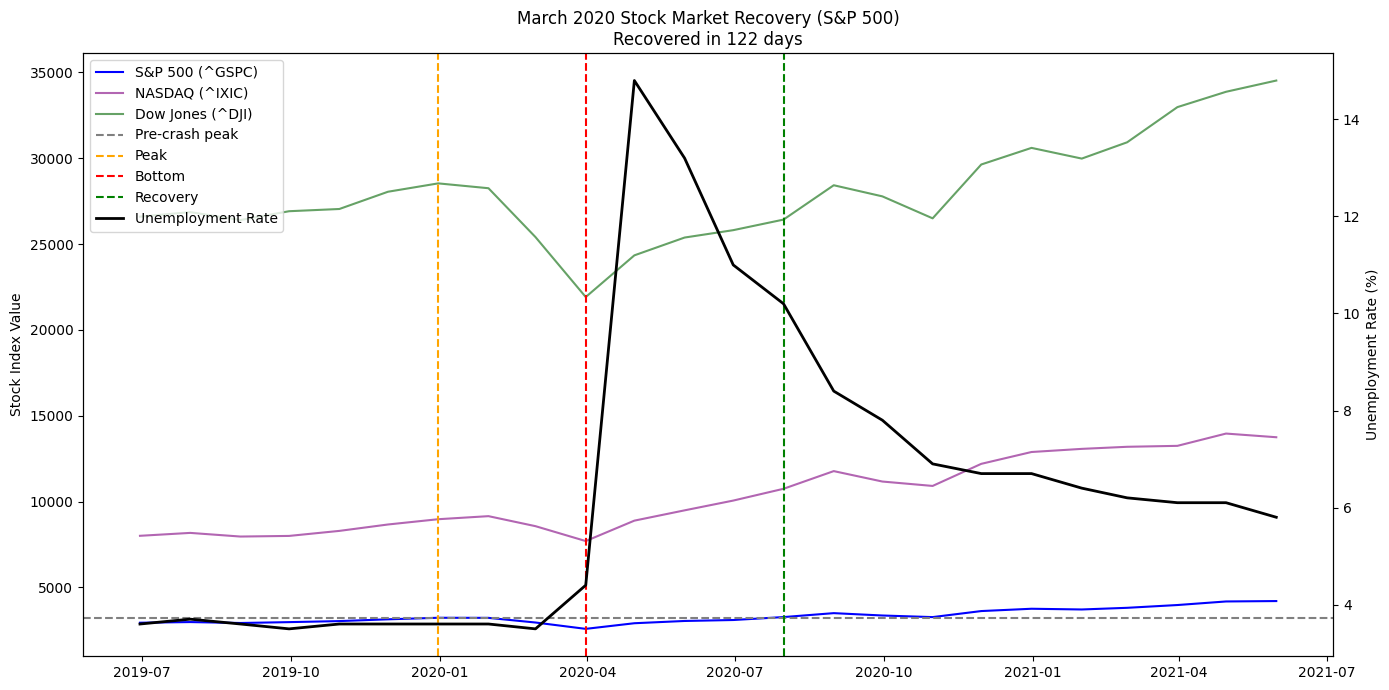

In [173]:
# Set the index to datetime data type
final_dataset.index = pd.to_datetime(final_dataset.index)

# Filter around the March 2020 period
start = '2019-06-01'
end = '2021-06-01'
final_filtered = final_dataset[(final_dataset['Date'] >= start) & (final_dataset['Date'] <= end)].copy()

# Focus recovery analysis on S&P 500 (^GSPC)
pre_crash_peak = final_filtered[final_filtered['Date'] < '2020-03-01']['^GSPC'].max()
peak_date = final_filtered[final_filtered['^GSPC'] == pre_crash_peak]['Date'].values[0]

# Find market bottom after the peak
post_peak = final_filtered[final_filtered['Date'] > peak_date]
bottom_row = post_peak.loc[post_peak['^GSPC'].idxmin()]
bottom_date = bottom_row['Date']
bottom_value = bottom_row['^GSPC']

# Find recovery date (when it reaches or exceeds pre-crash peak)
recovery_row = final_filtered[(final_filtered['Date'] > bottom_date) & (final_filtered['^GSPC'] >= pre_crash_peak)].iloc[0]
recovery_date = recovery_row['Date']
recovery_value = recovery_row['^GSPC']
days_to_recover = (recovery_date - bottom_date).days

# Plot all three indices and unemployment
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot stock indices
ax1.plot(final_filtered['Date'], final_filtered['^GSPC'], label='S&P 500 (^GSPC)', color='blue')
ax1.plot(final_filtered['Date'], final_filtered['^IXIC'], label='NASDAQ (^IXIC)', color='purple', alpha=0.6)
ax1.plot(final_filtered['Date'], final_filtered['^DJI'], label='Dow Jones (^DJI)', color='darkgreen', alpha=0.6)

# Highlight key S&P 500 events
ax1.axhline(pre_crash_peak, color='gray', linestyle='--', label='Pre-crash peak')
ax1.axvline(peak_date, color='orange', linestyle='--', label='Peak')
ax1.axvline(bottom_date, color='red', linestyle='--', label='Bottom')
ax1.axvline(recovery_date, color='green', linestyle='--', label='Recovery')

ax1.set_ylabel('Stock Index Value')
ax1.set_title(f'March 2020 Stock Market Recovery (S&P 500)\nRecovered in {days_to_recover} days')

# Plot unemployment on secondary axis
ax2 = ax1.twinx()
ax2.plot(final_filtered['Date'], final_filtered['Unemployment_Rate'], label='Unemployment Rate', color='black', linestyle='-', linewidth=2)
ax2.set_ylabel('Unemployment Rate (%)')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [174]:
# Pre-crash peak
print(f"Pre-Crash Peak of S&P 500: {pre_crash_peak} on {peak_date}")

# Market bottom
print(f"Bottom of S&P 500: {bottom_value} on {bottom_date}")

# Recovery point
print(f"Recovery of S&P 500: {recovery_value} on {recovery_date}")

# Days to recovery
print(f"Days to Recover for S&P 500: {days_to_recover} days")

# Unemployment spike
unemployment_spike_date = final_filtered[final_filtered['Unemployment_Rate'] == final_filtered['Unemployment_Rate'].max()]['Date'].values[0]
print(f"Unemployment Rate peaked at {final_filtered['Unemployment_Rate'].max()}% on {unemployment_spike_date}")

# Lag between unemployment spike and market bottom
lag_between_unemployment_and_bottom = (bottom_date - unemployment_spike_date).days
print(f"Days between unemployment spike and market bottom: {lag_between_unemployment_and_bottom} days")

Pre-Crash Peak of S&P 500: 3230.78 on 2019-12-31T00:00:00.000000000
Bottom of S&P 500: 2584.59 on 2020-03-31 00:00:00
Recovery of S&P 500: 3271.12 on 2020-07-31 00:00:00
Days to Recover for S&P 500: 122 days
Unemployment Rate peaked at 14.8% on 2020-04-30T00:00:00.000000000
Days between unemployment spike and market bottom: -30 days


# **Answer:** After this specific major spike in unemployment in 2020, the S&P 500 stock index took about 4 months (122 days) to recover. 

# **Question:** How long does it take for the Nasdaq stock index to recover after a major spike in unemployment?

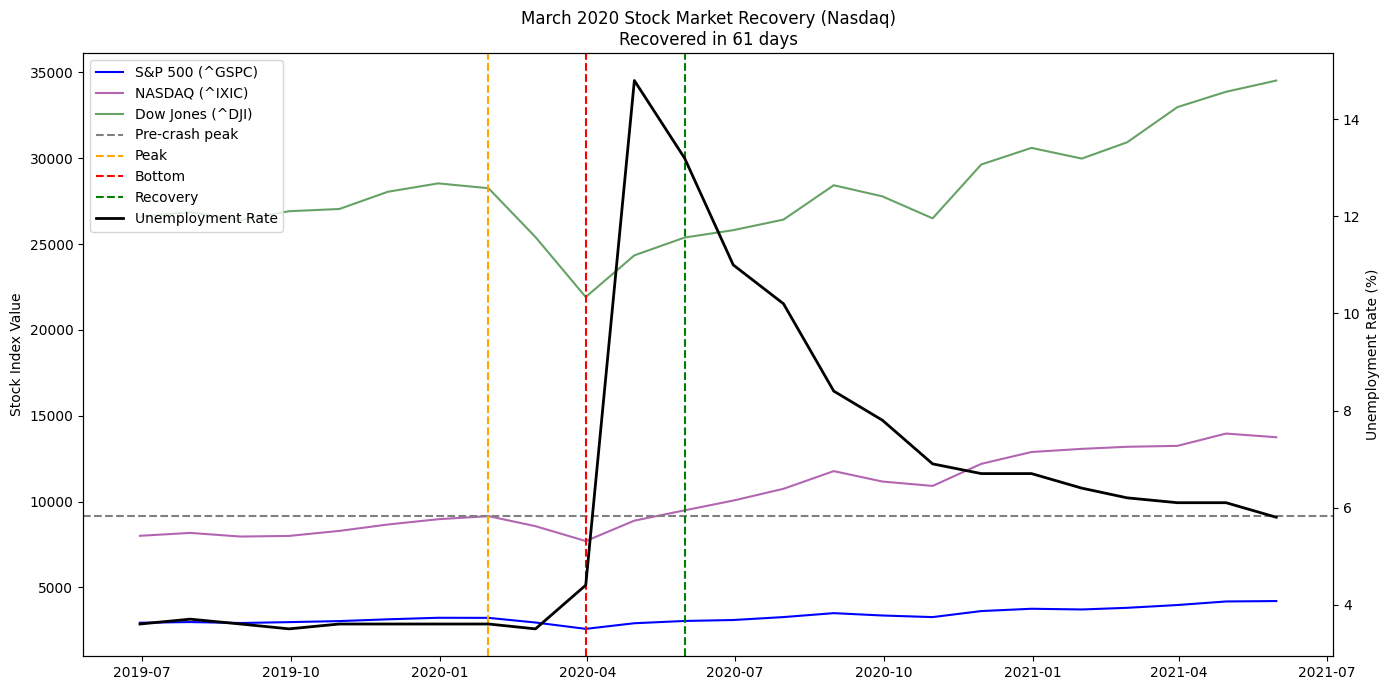

In [177]:
# Set the index to datetime data type
final_dataset.index = pd.to_datetime(final_dataset.index)

# Filter around the March 2020 period
start = '2019-06-01'
end = '2021-06-01'
final_filtered = final_dataset[(final_dataset['Date'] >= start) & (final_dataset['Date'] <= end)].copy()

# Focus recovery analysis on S&P 500 (^GSPC)
pre_crash_peak = final_filtered[final_filtered['Date'] < '2020-03-01']['^IXIC'].max()
peak_date = final_filtered[final_filtered['^IXIC'] == pre_crash_peak]['Date'].values[0]

# Find market bottom after the peak
post_peak = final_filtered[final_filtered['Date'] > peak_date]
bottom_row = post_peak.loc[post_peak['^IXIC'].idxmin()]
bottom_date = bottom_row['Date']
bottom_value = bottom_row['^IXIC']

# Find recovery date (when it reaches or exceeds pre-crash peak)
recovery_row = final_filtered[(final_filtered['Date'] > bottom_date) & (final_filtered['^IXIC'] >= pre_crash_peak)].iloc[0]
recovery_date = recovery_row['Date']
recovery_value = recovery_row['^IXIC']
days_to_recover = (recovery_date - bottom_date).days

# Plot all three indices and unemployment
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot stock indices
ax1.plot(final_filtered['Date'], final_filtered['^GSPC'], label='S&P 500 (^GSPC)', color='blue')
ax1.plot(final_filtered['Date'], final_filtered['^IXIC'], label='NASDAQ (^IXIC)', color='purple', alpha=0.6)
ax1.plot(final_filtered['Date'], final_filtered['^DJI'], label='Dow Jones (^DJI)', color='darkgreen', alpha=0.6)

# Highlight key S&P 500 events
ax1.axhline(pre_crash_peak, color='gray', linestyle='--', label='Pre-crash peak')
ax1.axvline(peak_date, color='orange', linestyle='--', label='Peak')
ax1.axvline(bottom_date, color='red', linestyle='--', label='Bottom')
ax1.axvline(recovery_date, color='green', linestyle='--', label='Recovery')

ax1.set_ylabel('Stock Index Value')
ax1.set_title(f'March 2020 Stock Market Recovery (Nasdaq)\nRecovered in {days_to_recover} days')

# Plot unemployment on secondary axis
ax2 = ax1.twinx()
ax2.plot(final_filtered['Date'], final_filtered['Unemployment_Rate'], label='Unemployment Rate', color='black', linestyle='-', linewidth=2)
ax2.set_ylabel('Unemployment Rate (%)')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [178]:
# Pre-crash peak
print(f"Pre-Crash Peak of Nasdaq: {pre_crash_peak} on {peak_date}")

# Market bottom
print(f"Bottom of Nasdaq: {bottom_value} on {bottom_date}")

# Recovery point
print(f"Recovery of Nasdaq: {recovery_value} on {recovery_date}")

# Days to recovery
print(f"Days to Recover for Nasdaq: {days_to_recover} days")

# Unemployment spike
unemployment_spike_date = final_filtered[final_filtered['Unemployment_Rate'] == final_filtered['Unemployment_Rate'].max()]['Date'].values[0]
print(f"Unemployment Rate peaked at {final_filtered['Unemployment_Rate'].max()}% on {unemployment_spike_date}")

# Lag between unemployment spike and market bottom
lag_between_unemployment_and_bottom = (bottom_date - unemployment_spike_date).days
print(f"Days between unemployment spike and market bottom: {lag_between_unemployment_and_bottom} days")

Pre-Crash Peak of Nasdaq: 9150.94 on 2020-01-31T00:00:00.000000000
Bottom of Nasdaq: 7700.1 on 2020-03-31 00:00:00
Recovery of Nasdaq: 9489.87 on 2020-05-31 00:00:00
Days to Recover for Nasdaq: 61 days
Unemployment Rate peaked at 14.8% on 2020-04-30T00:00:00.000000000
Days between unemployment spike and market bottom: -30 days


# **Answer:** After this specific major spike in unemployment in 2020, the Nasdaq stock index took about 2 months (61 days) to recover. 

# **Question:** How long does it take for the Dow Jones stock index to recover after a major spike in unemployment?

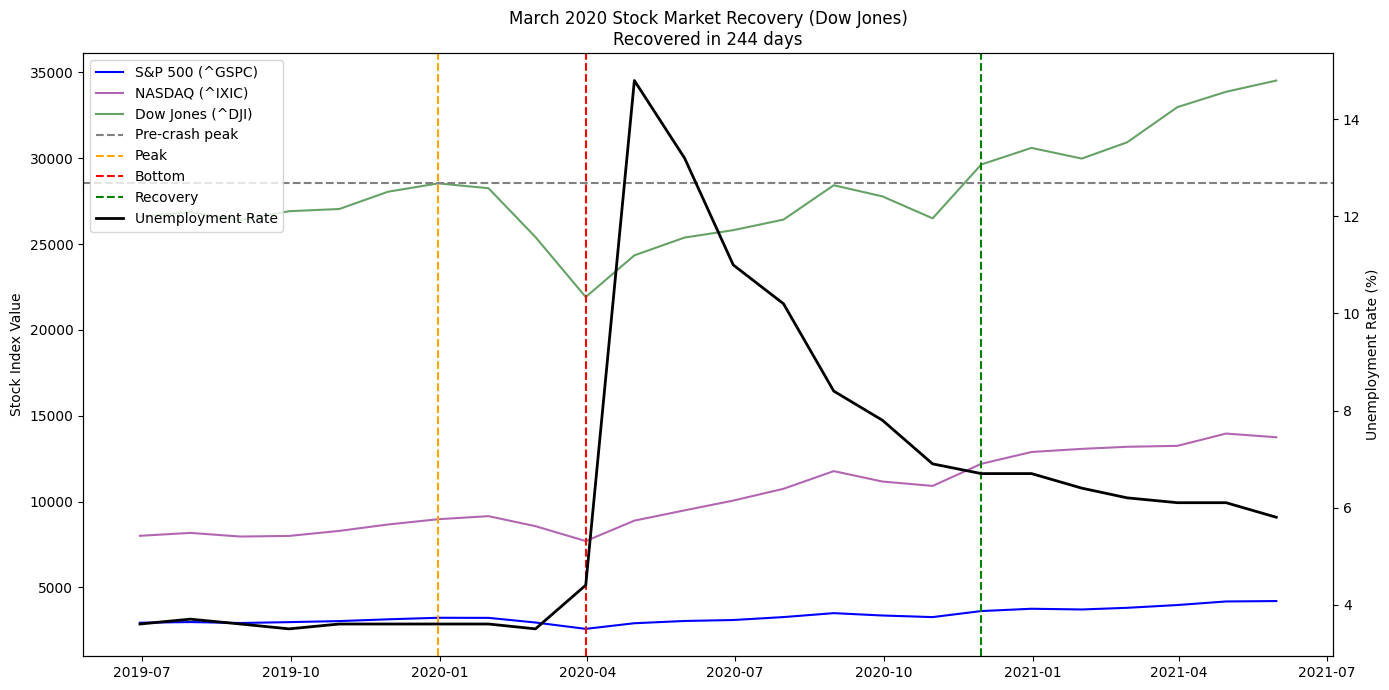

In [181]:
# Set the index to datetime data type
final_dataset.index = pd.to_datetime(final_dataset.index)

# Filter around the March 2020 period
start = '2019-06-01'
end = '2021-06-01'
final_filtered = final_dataset[(final_dataset['Date'] >= start) & (final_dataset['Date'] <= end)].copy()

# Focus recovery analysis on S&P 500 (^GSPC)
pre_crash_peak = final_filtered[final_filtered['Date'] < '2020-03-01']['^DJI'].max()
peak_date = final_filtered[final_filtered['^DJI'] == pre_crash_peak]['Date'].values[0]

# Find market bottom after the peak
post_peak = final_filtered[final_filtered['Date'] > peak_date]
bottom_row = post_peak.loc[post_peak['^DJI'].idxmin()]
bottom_date = bottom_row['Date']
bottom_value = bottom_row['^DJI']

# Find recovery date (when it reaches or exceeds pre-crash peak)
recovery_row = final_filtered[(final_filtered['Date'] > bottom_date) & (final_filtered['^DJI'] >= pre_crash_peak)].iloc[0]
recovery_date = recovery_row['Date']
recovery_value = recovery_row['^DJI']
days_to_recover = (recovery_date - bottom_date).days

# Plot all three indices and unemployment
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot stock indices
ax1.plot(final_filtered['Date'], final_filtered['^GSPC'], label='S&P 500 (^GSPC)', color='blue')
ax1.plot(final_filtered['Date'], final_filtered['^IXIC'], label='NASDAQ (^IXIC)', color='purple', alpha=0.6)
ax1.plot(final_filtered['Date'], final_filtered['^DJI'], label='Dow Jones (^DJI)', color='darkgreen', alpha=0.6)

# Highlight key S&P 500 events
ax1.axhline(pre_crash_peak, color='gray', linestyle='--', label='Pre-crash peak')
ax1.axvline(peak_date, color='orange', linestyle='--', label='Peak')
ax1.axvline(bottom_date, color='red', linestyle='--', label='Bottom')
ax1.axvline(recovery_date, color='green', linestyle='--', label='Recovery')

ax1.set_ylabel('Stock Index Value')
ax1.set_title(f'March 2020 Stock Market Recovery (Dow Jones)\nRecovered in {days_to_recover} days')

# Plot unemployment on secondary axis
ax2 = ax1.twinx()
ax2.plot(final_filtered['Date'], final_filtered['Unemployment_Rate'], label='Unemployment Rate', color='black', linestyle='-', linewidth=2)
ax2.set_ylabel('Unemployment Rate (%)')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [182]:
# Pre-crash peak
print(f"Pre-Crash Peak of Dow Jones: {pre_crash_peak} on {peak_date}")

# Market bottom
print(f"Bottom of Dow Jones: {bottom_value} on {bottom_date}")

# Recovery point
print(f"Recovery of Dow Jones: {recovery_value} on {recovery_date}")

# Days to recovery
print(f"Days to Recover for Dow Jones: {days_to_recover} days")

# Unemployment spike
unemployment_spike_date = final_filtered[final_filtered['Unemployment_Rate'] == final_filtered['Unemployment_Rate'].max()]['Date'].values[0]
print(f"Unemployment Rate peaked at {final_filtered['Unemployment_Rate'].max()}% on {unemployment_spike_date}")

# Lag between unemployment spike and market bottom
lag_between_unemployment_and_bottom = (bottom_date - unemployment_spike_date).days
print(f"Days between unemployment spike and market bottom: {lag_between_unemployment_and_bottom} days")

Pre-Crash Peak of Dow Jones: 28538.44 on 2019-12-31T00:00:00.000000000
Bottom of Dow Jones: 21917.16 on 2020-03-31 00:00:00
Recovery of Dow Jones: 29638.64 on 2020-11-30 00:00:00
Days to Recover for Dow Jones: 244 days
Unemployment Rate peaked at 14.8% on 2020-04-30T00:00:00.000000000
Days between unemployment spike and market bottom: -30 days


# **Answer:** After this specific major spike in unemployment in 2020, the Dow Jones stock index took about 8 months (244 days) to recover. 

# **Time Series Analysis**

# **Question:** Which method will forecast my data the best (have the lowest MAE)? 

In [314]:
# Display the final_dataset pandas DataFrame 

display(final_dataset)

,Unemployment_Rate,^GSPC,^IXIC,^DJI,Interest_Rate,Inflation_Rate,Decade,Unemployment_Group
Date,,,,,,,,
1992-01-31,7.3,408.78,620.21,3223.40,4.03,2.6,1990,Very High
1992-02-29,7.4,412.70,633.47,3267.70,4.06,2.8,1990,Very High
1992-03-31,7.4,403.69,603.77,3235.50,3.98,3.2,1990,Very High
1992-04-30,7.4,414.95,578.68,3359.10,3.73,3.2,1990,Very High
1992-05-31,7.6,415.35,585.31,3396.90,3.82,3.0,1990,Very High
...,...,...,...,...,...,...,...,...
2024-10-31,4.1,5705.45,18095.15,41763.46,4.83,2.6,2020,Very Low
2024-11-30,4.2,6032.38,19218.17,44910.65,4.64,2.7,2020,Very Low
2024-12-31,4.1,5881.63,19310.79,42544.22,4.48,2.9,2020,Very Low


In [187]:
# Find the NaN values in the columns to make sure there are none 

print(final_dataset.isna().sum())

Date                  0
Unemployment_Rate     0
^GSPC                 0
^IXIC                 0
^DJI                  0
Interest_Rate         0
Inflation_Rate        0
Decade                0
Unemployment_Group    0
dtype: int64


In [188]:
# Ensure the 'Date' column is in datetime format
final_dataset['Date'] = pd.to_datetime(final_dataset['Date'], errors='coerce')

# Set 'Date' as the index
final_dataset.set_index('Date', inplace=True)

# Sort the index in case it's not already sorted
final_dataset.sort_index(inplace=True)

# (Optional but recommended) Drop any rows with missing values
final_dataset = final_dataset.dropna()

In [316]:
# Display the final_dataset pandas DataFrame 

display(final_dataset)

,Unemployment_Rate,^GSPC,^IXIC,^DJI,Interest_Rate,Inflation_Rate,Decade,Unemployment_Group
Date,,,,,,,,
1992-01-31,7.3,408.78,620.21,3223.40,4.03,2.6,1990,Very High
1992-02-29,7.4,412.70,633.47,3267.70,4.06,2.8,1990,Very High
1992-03-31,7.4,403.69,603.77,3235.50,3.98,3.2,1990,Very High
1992-04-30,7.4,414.95,578.68,3359.10,3.73,3.2,1990,Very High
1992-05-31,7.6,415.35,585.31,3396.90,3.82,3.0,1990,Very High
...,...,...,...,...,...,...,...,...
2024-10-31,4.1,5705.45,18095.15,41763.46,4.83,2.6,2020,Very Low
2024-11-30,4.2,6032.38,19218.17,44910.65,4.64,2.7,2020,Very Low
2024-12-31,4.1,5881.63,19310.79,42544.22,4.48,2.9,2020,Very Low


In [190]:
# Drop all NaN values from your entire dataset at the beginning
final_dataset = final_dataset.dropna()

# Ensure the 'Date' index is in datetime format
final_dataset.index = pd.to_datetime(final_dataset.index, errors='coerce')

# Set frequency to monthly (if not already set)
final_dataset = final_dataset.asfreq('M')

# Split into train and test sets
train = final_dataset[final_dataset.index <= '2021-12-31']
test = final_dataset[final_dataset.index >= '2022-01-31']

# Check if train and test sets are correctly split
print(f"Train dataset length: {len(train)}")
print(f"Test dataset length: {len(test)}")

# Forecasting Methods

# 1. Moving Average (n=4)
ma_4 = train['Unemployment_Rate'].rolling(window=4).mean()
ma_4_test = ma_4[-len(test):]

# 2. Moving Average (n=6)
ma_6 = train['Unemployment_Rate'].rolling(window=6).mean()
ma_6_test = ma_6[-len(test):]

# Simple Exponential Smoothing (alpha=0.8)
ses_04_08 = SimpleExpSmoothing(train['Unemployment_Rate']).fit(smoothing_level=0.8, optimized=False)
ses_04_08_forecast = ses_04_08.forecast(len(test))
ses_04_08_fitted = ses_04_08.fittedvalues  

# Simple Exponential Smoothing (alpha=0.2)
ses_04_02 = SimpleExpSmoothing(train['Unemployment_Rate']).fit(smoothing_level=0.2, optimized=False)
ses_04_02_forecast = ses_04_02.forecast(len(test))
ses_04_02_fitted = ses_04_02.fittedvalues  

# Simple Exponential Smoothing (span=6, alpha=0.8)
ses_06_08 = SimpleExpSmoothing(train['Unemployment_Rate']).fit(smoothing_level=0.8, optimized=False)
ses_06_08_forecast = ses_06_08.forecast(len(test))
ses_06_08_fitted = ses_06_08.fittedvalues  

# Simple Exponential Smoothing (span=6, alpha=0.2)
ses_06_02 = SimpleExpSmoothing(train['Unemployment_Rate']).fit(smoothing_level=0.2, optimized=False)
ses_06_02_forecast = ses_06_02.forecast(len(test))
ses_06_02_fitted = ses_06_02.fittedvalues  

# Holt-Winters (Additive)
hw_add = ExponentialSmoothing(train['Unemployment_Rate'], seasonal='add', seasonal_periods=12).fit()
hw_add_forecast = hw_add.forecast(len(test))
hw_add_fitted = hw_add.fittedvalues

# Holt-Winters (Multiplicative)
hw_mul = ExponentialSmoothing(train['Unemployment_Rate'], seasonal='mul', seasonal_periods=12).fit()
hw_mul_forecast = hw_mul.forecast(len(test))
hw_mul_fitted = hw_mul.fittedvalues

# TBATS
model_tbats = TBATS(seasonal_periods=[12]).fit(train['Unemployment_Rate'])
tbats_forecast = model_tbats.forecast(steps=len(test))

# MAE Calculation Function
def calculate_mae(actual, predicted):
    return mean_absolute_error(actual, predicted)

# MAE for all methods

# Moving Averages (n=4, n=6)
ma_4_mae = calculate_mae(test['Unemployment_Rate'], ma_4_test)
ma_6_mae = calculate_mae(test['Unemployment_Rate'], ma_6_test)

# SES (alpha=0.8)
ses_04_08_mae = calculate_mae(test['Unemployment_Rate'], ses_04_08_forecast)

# SES (alpha=0.2)
ses_04_02_mae = calculate_mae(test['Unemployment_Rate'], ses_04_02_forecast)

# SES (span=6, alpha=0.8)
ses_06_08_mae = calculate_mae(test['Unemployment_Rate'], ses_06_08_forecast)

# SES (span=6, alpha=0.2)
ses_06_02_mae = calculate_mae(test['Unemployment_Rate'], ses_06_02_forecast)

# Holt-Winters Additive
hw_add_mae = calculate_mae(test['Unemployment_Rate'], hw_add_forecast)

# Holt-Winters Multiplicative
hw_mul_mae = calculate_mae(test['Unemployment_Rate'], hw_mul_forecast)

# TBATS
tbats_mae = calculate_mae(test['Unemployment_Rate'], tbats_forecast)

# Collecting results
forecast_methods = [
    ('MA (n=4)', ma_4_mae),
    ('MA (n=6)', ma_6_mae),
    ('SES (alpha=0.8)', ses_04_08_mae),
    ('SES (alpha=0.2)', ses_04_02_mae),
    ('SES (span=6, alpha=0.8)', ses_06_08_mae),
    ('SES (span=6, alpha=0.2)', ses_06_02_mae),
    ('HW (Additive)', hw_add_mae),
    ('HW (Multiplicative)', hw_mul_mae), 
    ('TBATS', tbats_mae)  
]

# Output the results
print("Forecast Methods and Their MAEs:")
for method, mae in forecast_methods:
    print(f"{method}: MAE = {mae}")

mae_df = pd.DataFrame(forecast_methods, columns=['Forecast Method', 'MAE'])

# Sort by MAE (optional, for easier comparison)
mae_df = mae_df.sort_values(by='MAE')

# Display the DataFrame
display(mae_df)

Train dataset length: 360
Test dataset length: 38
Forecast Methods and Their MAEs:
MA (n=4): MAE = 1.8289473684210533
MA (n=6): MAE = 1.805701754385965
SES (alpha=0.8): MAE = 0.2628915804773348
SES (alpha=0.2): MAE = 1.1819379573836482
SES (span=6, alpha=0.8): MAE = 0.2628915804773348
SES (span=6, alpha=0.2): MAE = 1.1819379573836482
HW (Additive): MAE = 0.2951500544155784
HW (Multiplicative): MAE = 0.2676716406768741
TBATS: MAE = 0.2239735775113227


,Forecast Method,MAE
8,TBATS,0.223974
2,SES (alpha=0.8),0.262892
4,"SES (span=6, alpha=0.8)",0.262892
7,HW (Multiplicative),0.267672
6,HW (Additive),0.295150
3,SES (alpha=0.2),1.181938
5,"SES (span=6, alpha=0.2)",1.181938
1,MA (n=6),1.805702
0,MA (n=4),1.828947


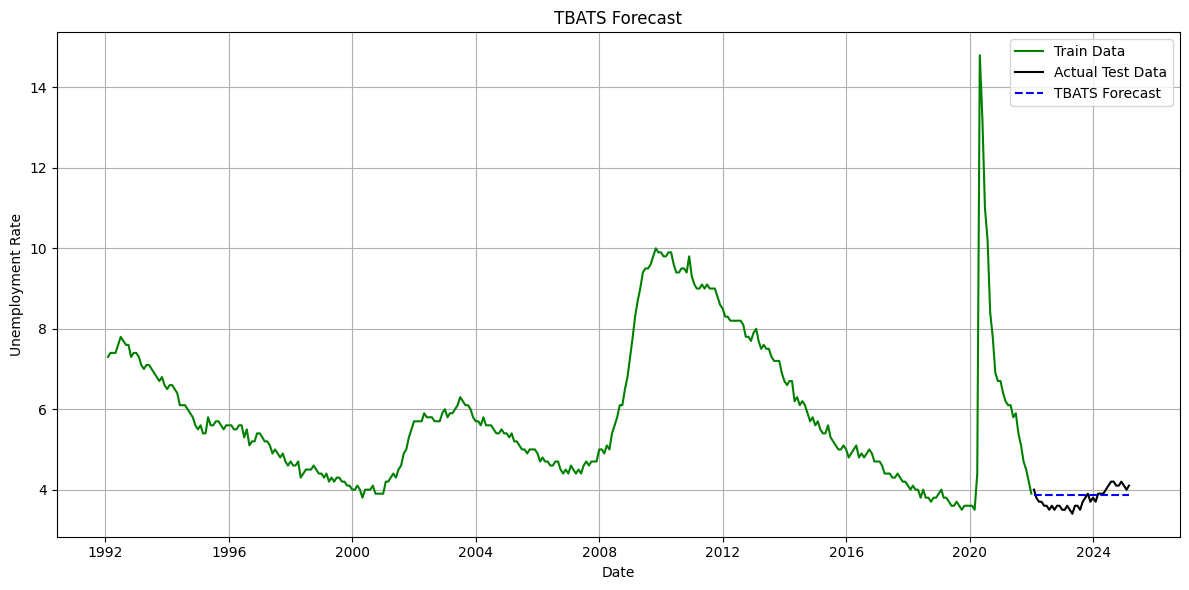

In [191]:
# Plotting train data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Unemployment_Rate'], label='Train Data', color='green')

# Plotting actual test data
plt.plot(test.index, test['Unemployment_Rate'], label='Actual Test Data', color='black')

# Plotting TBATS forecast
plt.plot(test.index, tbats_forecast, label='TBATS Forecast', color='blue', linestyle='--')

plt.title('TBATS Forecast')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

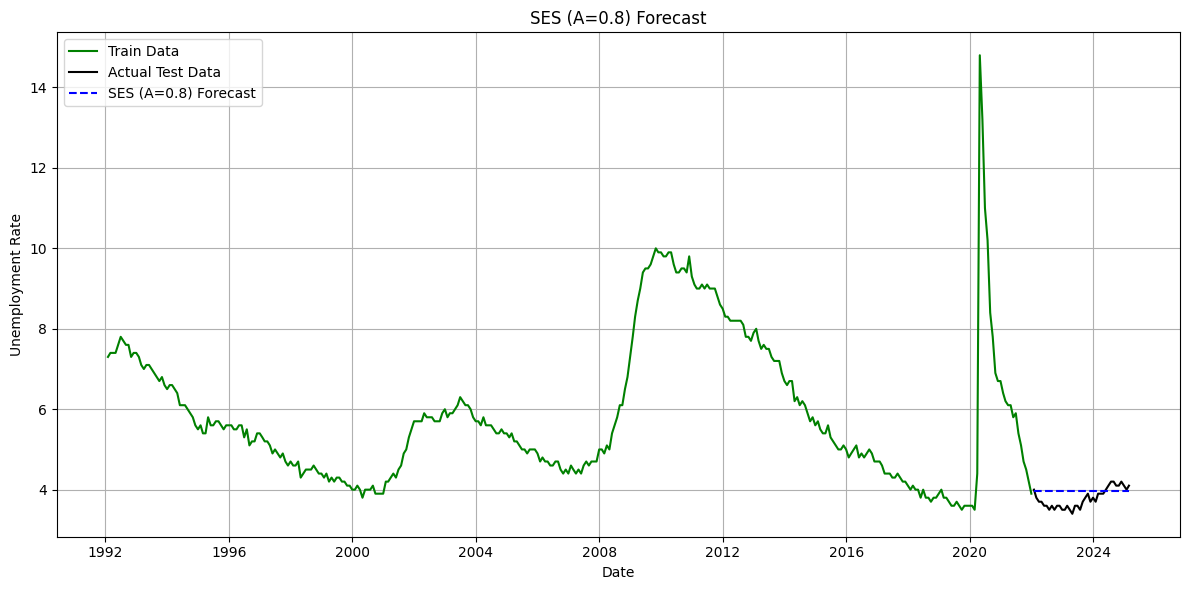

In [192]:
# Plotting train data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Unemployment_Rate'], label='Train Data', color='green')

# Plotting actual test data
plt.plot(test.index, test['Unemployment_Rate'], label='Actual Test Data', color='black')

# Plotting SES (alpha=0.8) forecast
plt.plot(test.index, ses_04_08_forecast, label='SES (A=0.8) Forecast', color='blue', linestyle='--')

plt.title('SES (A=0.8) Forecast')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

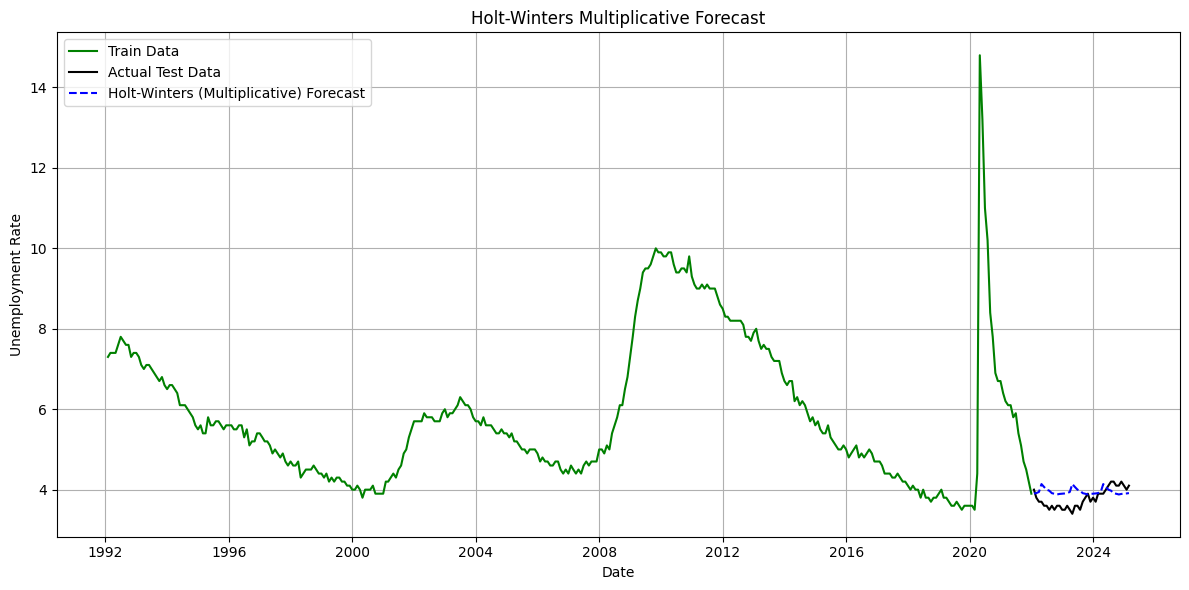

In [193]:
# Plotting train data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Unemployment_Rate'], label='Train Data', color='green')

# Plotting actual test data
plt.plot(test.index, test['Unemployment_Rate'], label='Actual Test Data', color='black')

# Plotting SES (alpha=0.8) forecast
plt.plot(test.index, hw_mul_forecast, label='Holt-Winters (Multiplicative) Forecast', color='blue', linestyle='--')

plt.title('Holt-Winters Multiplicative Forecast')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

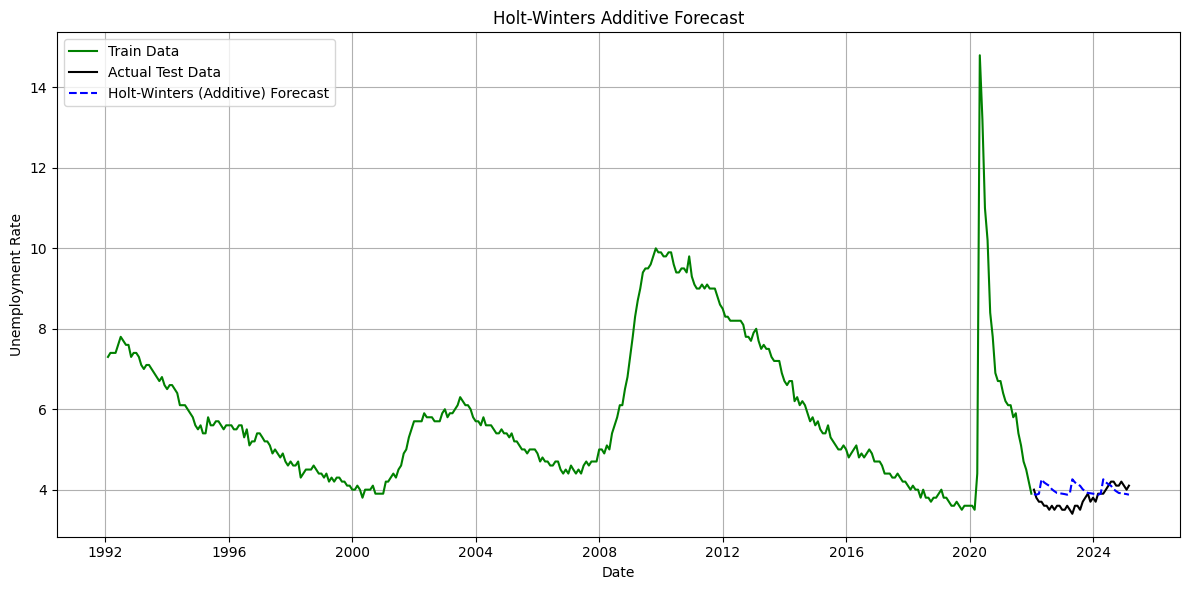

In [194]:
# Plotting train data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Unemployment_Rate'], label='Train Data', color='green')

# Plotting actual test data
plt.plot(test.index, test['Unemployment_Rate'], label='Actual Test Data', color='black')

# Plotting SES (alpha=0.8) forecast
plt.plot(test.index, hw_add_forecast, label='Holt-Winters (Additive) Forecast', color='blue', linestyle='--')

plt.title('Holt-Winters Additive Forecast')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Answer:** 